In [3]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [4]:
import os
from collections import defaultdict
import numpy as np
import scipy.stats as stats
import scipy.integrate as integrate
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from bgspy.theory import bgs_segment, bgs_rec, bgs_segment_sc16, bgs_rec_sc16
from bgspy.theory import bgs_segment_sc16_grid, bgs_segment_sc16_grid_alt, bgs_rec_sc16_alt
from bgspy.utils import signif, rel_error

In [5]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')

In [6]:
def group_means(d):
    d_ave = d.groupby(['key']).mean().reset_index()
    #d_var = d.groupby(['key'])['y', 'r2_sum', 'r2_mean', 'ld_sum', 'ld_mean'].var().reset_index()
    #d_var = d_var.rename(columns={'y': 'y_var'})
    #d_grp = pd.concat((d_ave, d_var), axis=1).reset_index()
    return d_ave.sort_values(['sh', 'mu'])

def load_validation(file):
    vda = np.load(file, allow_pickle=True)
    vd = pd.DataFrame(vda['X'], columns=vda['features'])
    vdy = pd.DataFrame(vda['y'], columns=vda['targets'])
    vd['y'] = vdy['Bhat'].astype('float')
    vd['key'] = vda['keys']
    #@vd['theory'] = bgs_segment(vd['mu'], vd['sh'], vd['L'], vd['rbp'], vd['rf'])
    vd['Ef'] = vdy['Ef'].astype('float')
    vd['Vf'] = vdy['Vf'].astype('float')
    vd['load'] = vdy['load']
    vd['nsubs'] = vdy['nsubs'] 
    vd['r2_sum'] = vdy['r2_sum']
    vd['r2_mean'] = vdy['r2_mean']
    vd['ld_sum'] = vdy['ld_sum']
    vd['ld_mean'] = vdy['ld_mean']
    vd['U'] = vd['L'] * vd['mu']
    vd['R'] = [np.max(x) / len(x) for x in vd['nsubs']]
    return vd


## Validation

In [7]:
force = True
cache_file = '../data/slim_sims/validate/validate.pkl'

if force or not os.path.exists(cache_file):
    vd = load_validation('../data/slim_sims/validate/validate.npz')    
    vd.to_pickle('../data/slim_sims/validate/validate.pkl')
else:    
    vd = pd.read_pickle(cache_file)


In [8]:
vd['r2_sum'] = np.fromiter(map(float, vd['r2_sum']), dtype=float)
vd['r2_mean'] = np.fromiter(map(float, vd['r2_mean']), dtype=float)
vd['ld_mean'] = np.fromiter(map(float, vd['ld_mean']), dtype=float)

In [9]:
vg = group_means(vd)
vg['rate'] = vd.U / vd.sh

In [10]:
vg.head()

,key,mu,sh,L,rbp,rf,rep,y,Ef,Vf,r2_sum,r2_mean,ld_mean,U,R,rate
44,validate_N1000_mu1e-09_sh1e-05_rf0.0001_rbp1e-...,1.000000e-09,0.000010,10000.0,1.000000e-08,1.000000e-04,4999.5,0.999451,0.999999,3.721994e-12,0.009313,0.060169,0.029686,0.00001,0.000008,0.017783
45,validate_N1000_mu1e-09_sh1e-05_rf1e-09_rbp1e-0...,1.000000e-09,0.000010,10000.0,1.000000e-08,1.000000e-09,4999.5,0.999529,0.999999,3.890335e-12,0.008216,0.060775,0.031817,0.00001,0.000008,1.000000
20,validate_N1000_mu1e-08_sh1e-05_rf0.0001_rbp1e-...,1.000000e-08,0.000010,10000.0,1.000000e-08,1.000000e-04,4999.5,0.997767,0.999992,3.920721e-11,0.447285,0.060925,0.001474,0.00010,0.000080,3.162278
21,validate_N1000_mu1e-08_sh1e-05_rf1e-09_rbp1e-0...,1.000000e-08,0.000010,10000.0,1.000000e-08,1.000000e-09,4999.5,1.002007,0.999992,3.984778e-11,0.448559,0.062674,0.001413,0.00010,0.000079,0.031623
46,validate_N1000_mu1e-09_sh3.16227766e-05_rf0.00...,1.000000e-09,0.000032,10000.0,1.000000e-08,1.000000e-04,4999.5,0.994058,0.999998,3.905819e-11,0.010386,0.074017,0.030952,0.00001,0.000008,0.001778


## Theory Validation

[]

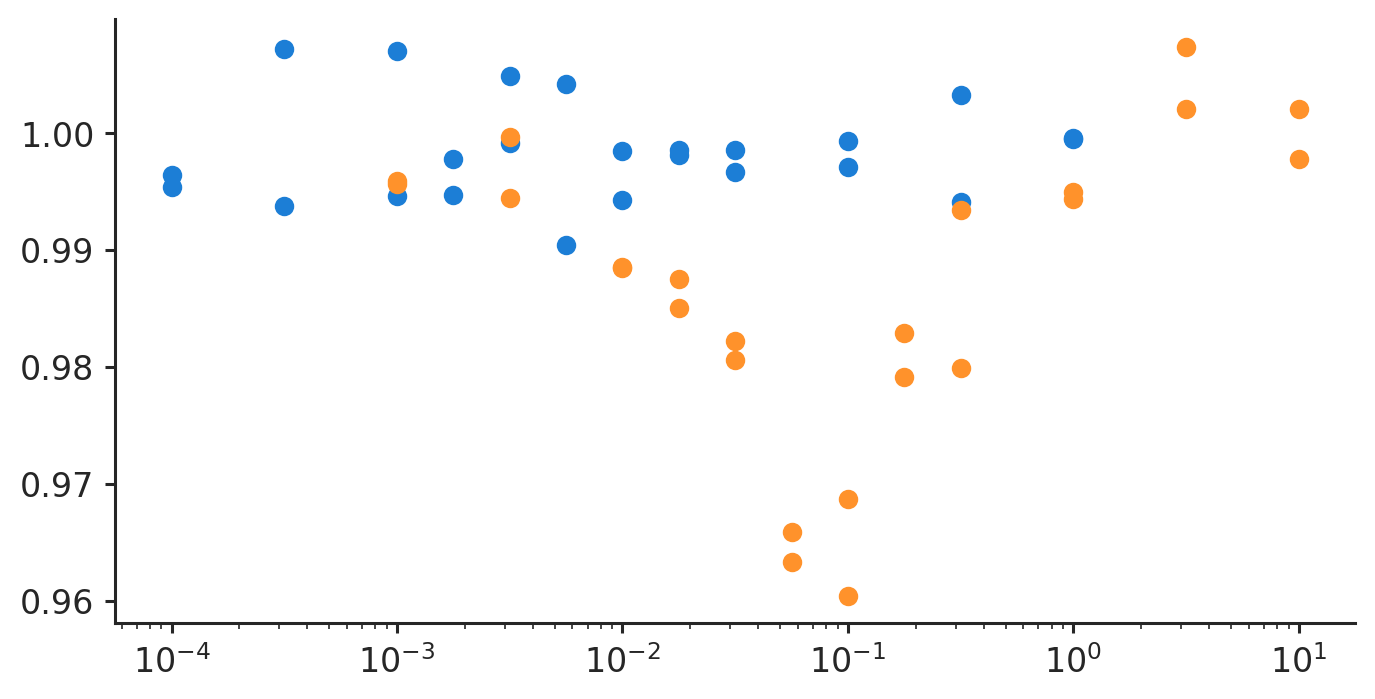

In [16]:
f, ax = plt.subplots()

for u in vg['U'].unique():
    vgs = vg.loc[vg.U == u]
    rate = vgs['U']/vgs['sh']
    ax.scatter(rate, vgs['y'], label=f"U = {u}")# c=np.log10(vgs['sh']))
plt.semilogx()

Text(0.5, 0, 'T')

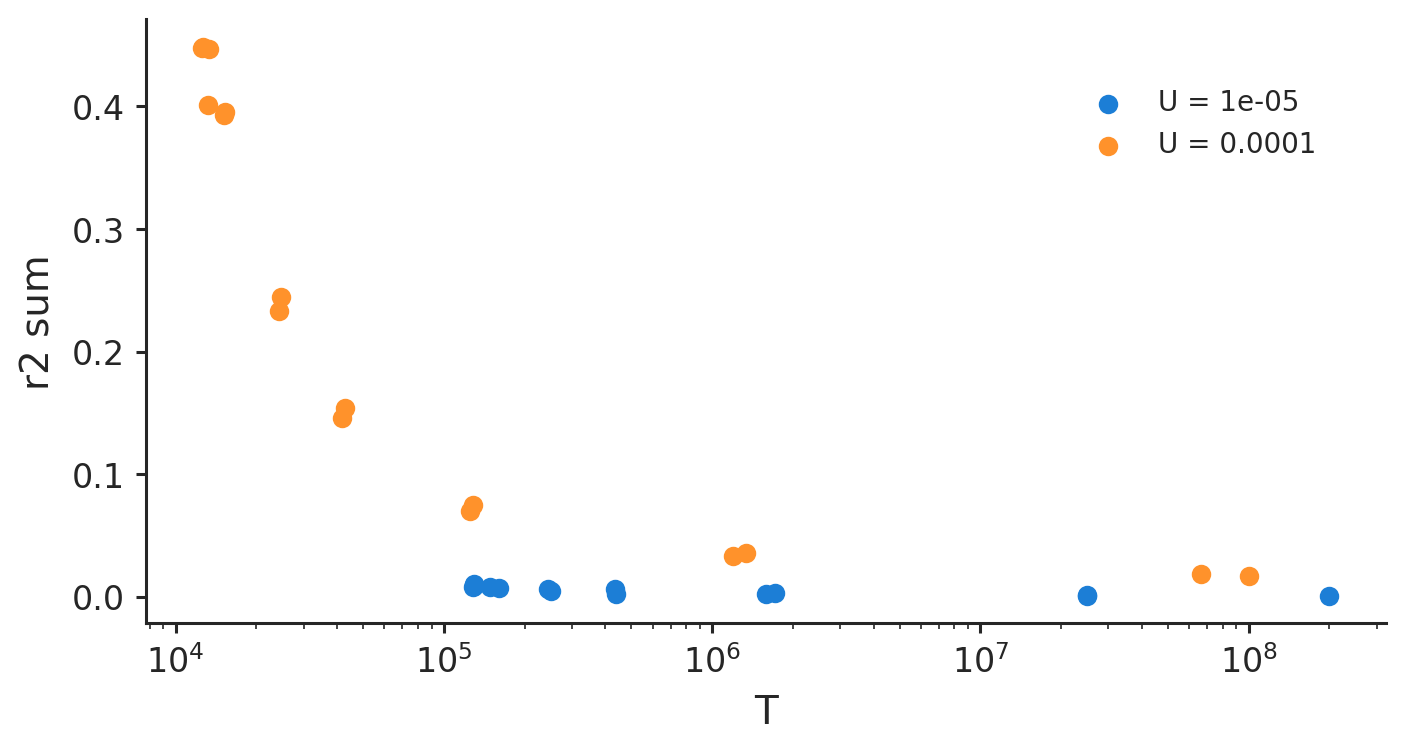

In [59]:
f, ax = plt.subplots()

for u in vg['U'].unique():
    vgs = vg.loc[vg.U == u]
    ax.scatter(1/vgs['R'], vgs['r2_sum'], label=f"U = {u}")# c=np.log10(vgs['sh']))
ax.semilogx()
ax.legend()
ax.set_ylabel('r2 sum')
ax.set_xlabel('T')

In [45]:
N = 1000
rbp = 1e-8
ok71(rbp*4*N)

0.4545365291035276

In [36]:
def ok71(rho):
    return (10 + rho) / (22 + 13*rho + rho**2)


@np.vectorize
def neutral_ld(L, rbp, N, s=None, u=None):
    # N is *diploid* pop size
    R = rbp * L
    #fun = lambda x: ok71(4*N*0.5*(1 - np.exp(-0.5 * rbp*x))) * (2-2*x) * R
    if s is None:
        fun = lambda x: ok71(4*N*rbp*x) * (2-2*x) * R
    else:
        fun = lambda x: ok69_sel(2*N, x*rbp, s, u)
    return integrate.quad(fun, 0, 1)[0]

In [39]:
neutral_ld(1, 1e-8, 1000), ok71(1e-8 * 1000 * 4)

(array(4.54542479e-09), 0.4545365291035276)

[]

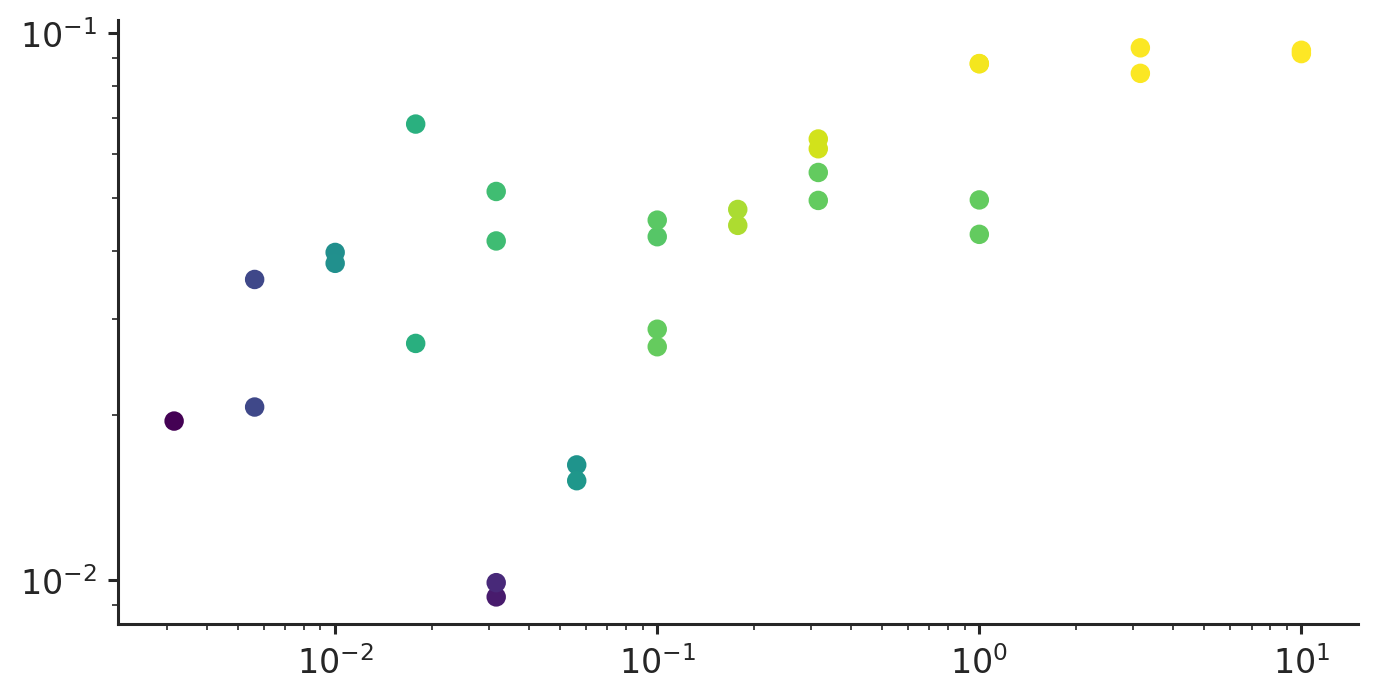

In [67]:
f, ax = plt.subplots()
ax.scatter(vg['U']/vg['sh'], vg['r2_sum']/vg['nld'], c=np.log10(vg['R']))
ax.loglog()

/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0, 'U/sh')

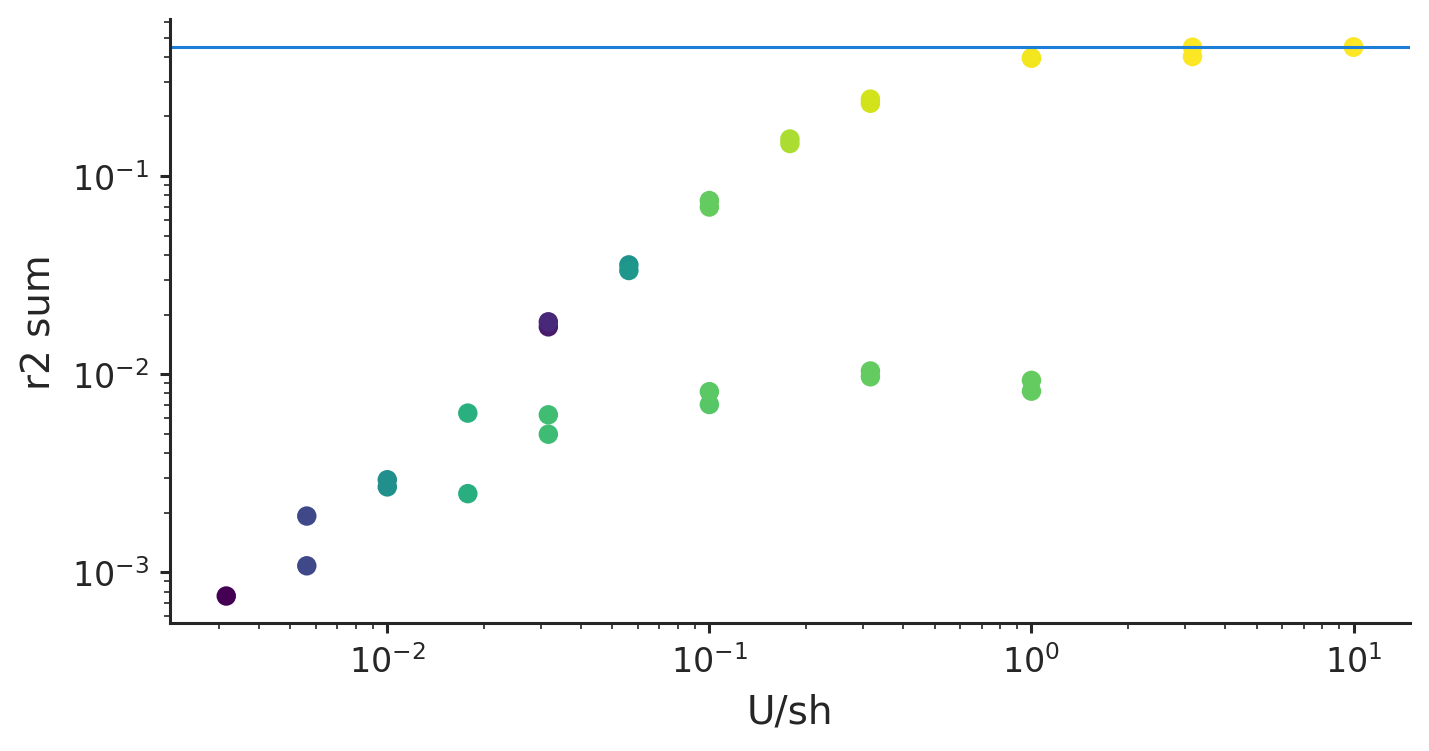

In [62]:
f, ax = plt.subplots()

ax.scatter(vg['U']/vg['sh'], vg['r2_sum'], c=np.log10(vg['R']))
ax.loglog()
L = 10_000
rbp = 1e-8
n = 100
ax.axhline((n * (n-1) + 1)*neutral_ld(L, rbp, 1000))
ax.set_ylabel('r2 sum')
ax.set_xlabel('U/sh')

NameError: name 'sh' is not defined

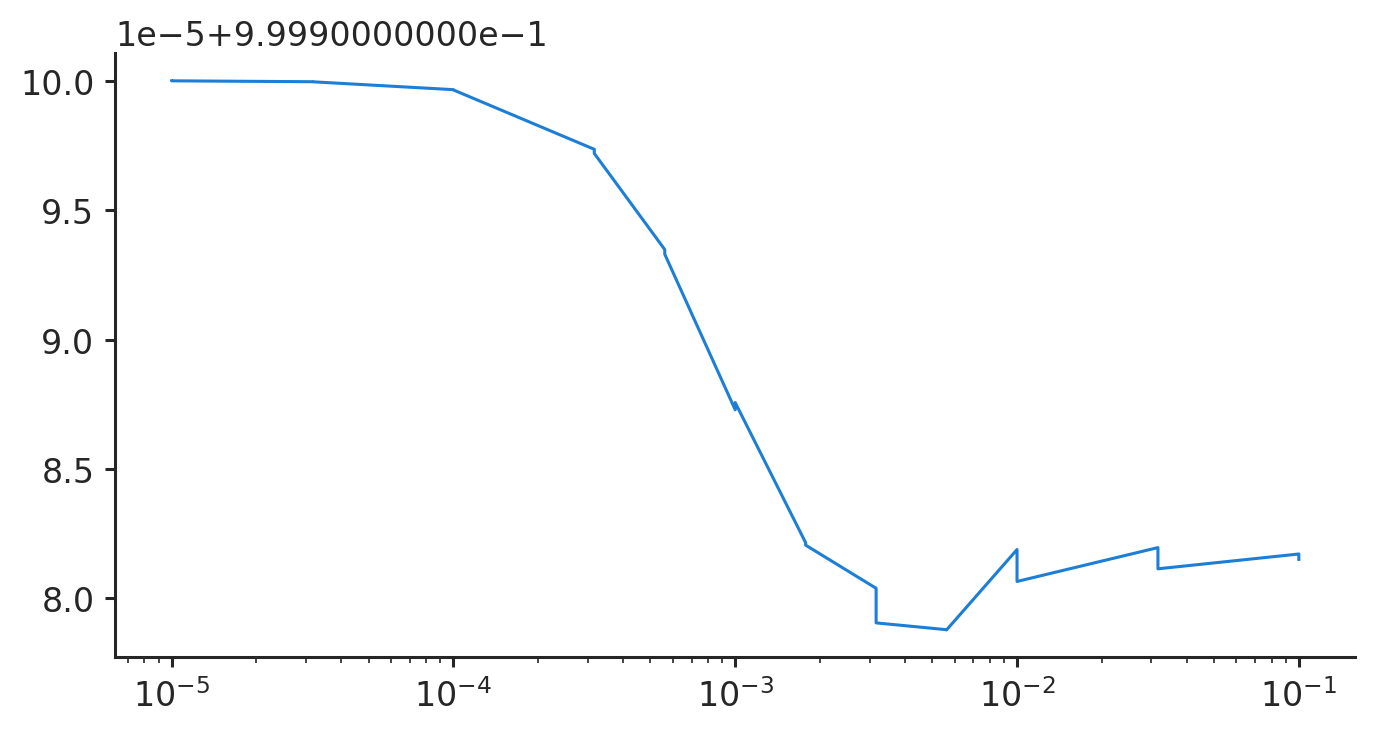

In [50]:
f, ax = plt.subplots()
ax.semilogx()
#sns.scatterplot(data=vg, x='sh', y='pop_fit_var', hue='mu', ax=ax)
for u in vg['U'].unique():
    vgs = vg.loc[vg.U == u]
    Vf = vgs.Vf
    r = vgs['rf'].unique()[0]
    res = bgs_segment_sc16(u, vgs.sh, 1, r, N, return_both=True)
    Q2 = res[2]
    
    # empirical variance -- note the factor of two error here! 
    lines = plt.plot(vgs.sh, np.exp(-1/2*Vf*Q2))
    
    res = bgs_segment_sc16(u, sh, 1, r, N, return_both=True)
    V = res[3]
    Q2 = res[2]
    Ne = res[1]
    # imputed variance
    #plt.plot(sh, np.exp(-V*Q2*2), c=lines[0].get_color(), linestyle='dashed')
    N = 1000
    plt.plot(sh, Ne/N, c=lines[0].get_color(), linestyle='dashed')
plt.semilogx()

Text(0.5, 0, 'sel coef')

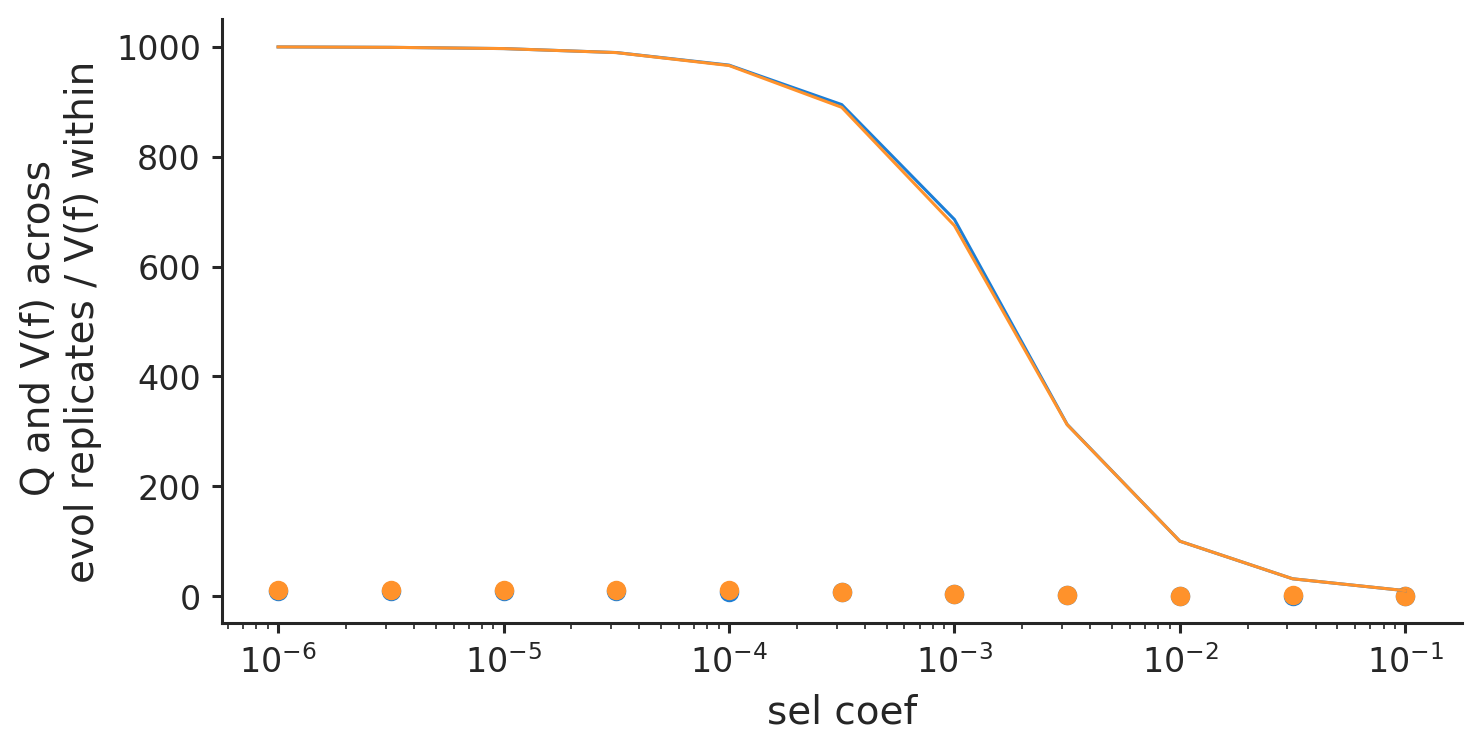

In [391]:
f, ax = plt.subplots()
ax.semilogx()
#sns.scatterplot(data=vg, x='sh', y='pop_fit_var', hue='mu', ax=ax)
for u in vg['U'].unique():
    vgs = vg.loc[vg.U == u]
    Vf = vgs.Vf
    r = vgs['rf'].unique()[0]
    res = bgs_segment_sc16(u, vgs.sh, 1, 1e-8, N, Q_segment=True, return_both=True)
    Q2 = res[2]
    V = res[3]
    #plt.scatter(vgs.sh, vgs.pop_fit_var)
    Q = np.sqrt(Q2)
    scaling_term = 10 # this is chosen to get a good visual fit!
    ax.scatter(vgs.sh, (vgs.pop_fit_var/vgs.Vf)**2)
    
    # at a certain point, Q is just determined by Z = 1-1/2N
    
    ax.plot(vgs.sh, Q)

ax.set_ylabel("Q and V(f) across \nevol replicates / V(f) within")
ax.set_xlabel("sel coef")


[]

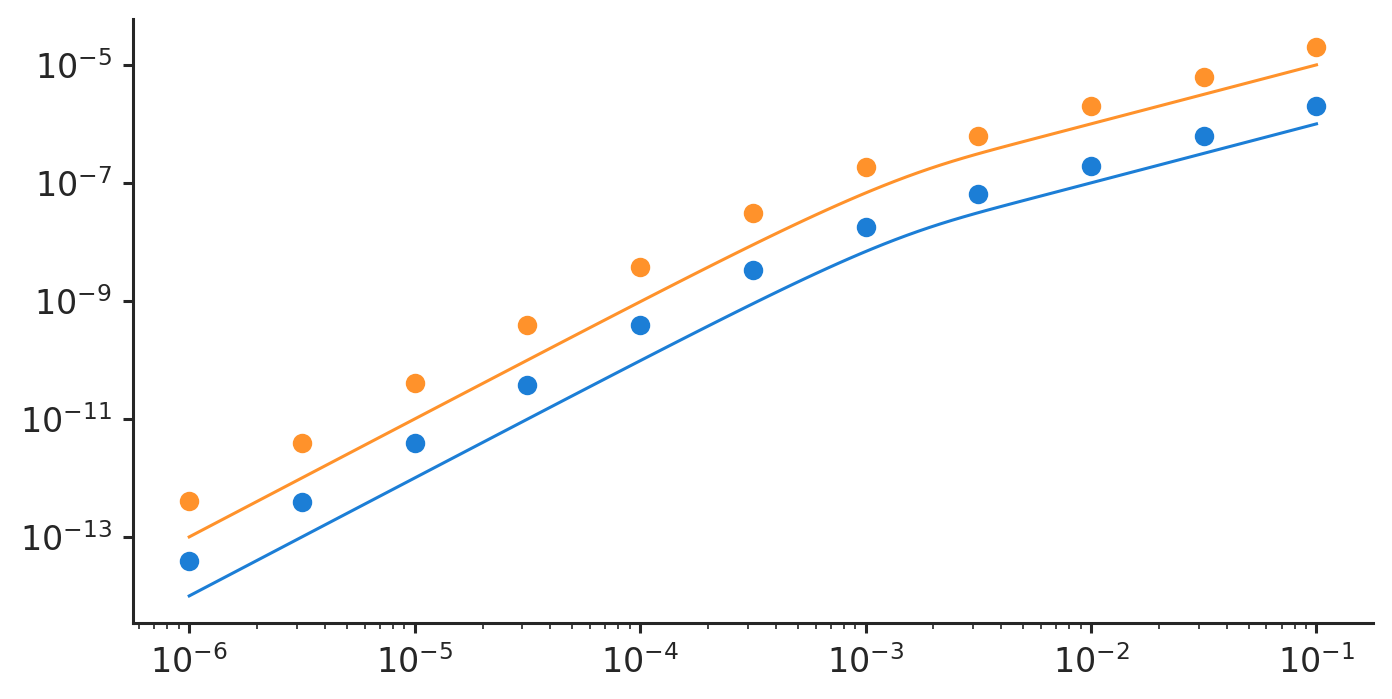

In [190]:
f, ax = plt.subplots()
ax.semilogx()
#sns.scatterplot(data=vg, x='sh', y='pop_fit_var', hue='mu', ax=ax)
for u in vg['U'].unique():
    vgs = vg.loc[vg.U == u]
    Vf = vgs.Vf
    r = vgs['rf'].unique()[0]
    res = bgs_segment_sc16(u, sh, 1, r, N, return_both=True)
    Q2 = res[2]
    V = res[3]
    plt.plot(sh, V)
    plt.scatter(vgs['sh'], Vf) # TODO factor
plt.loglog()

In [96]:
sh = np.logspace(-6, -1, 100)

/tmp/ipykernel_75194/1592018779.py:15: RuntimeWarning: divide by zero encountered in true_divide
  T = 1/R
/tmp/ipykernel_75194/1592018779.py:15: RuntimeWarning: divide by zero encountered in true_divide
  T = 1/R


(1e-08, 0.0001)

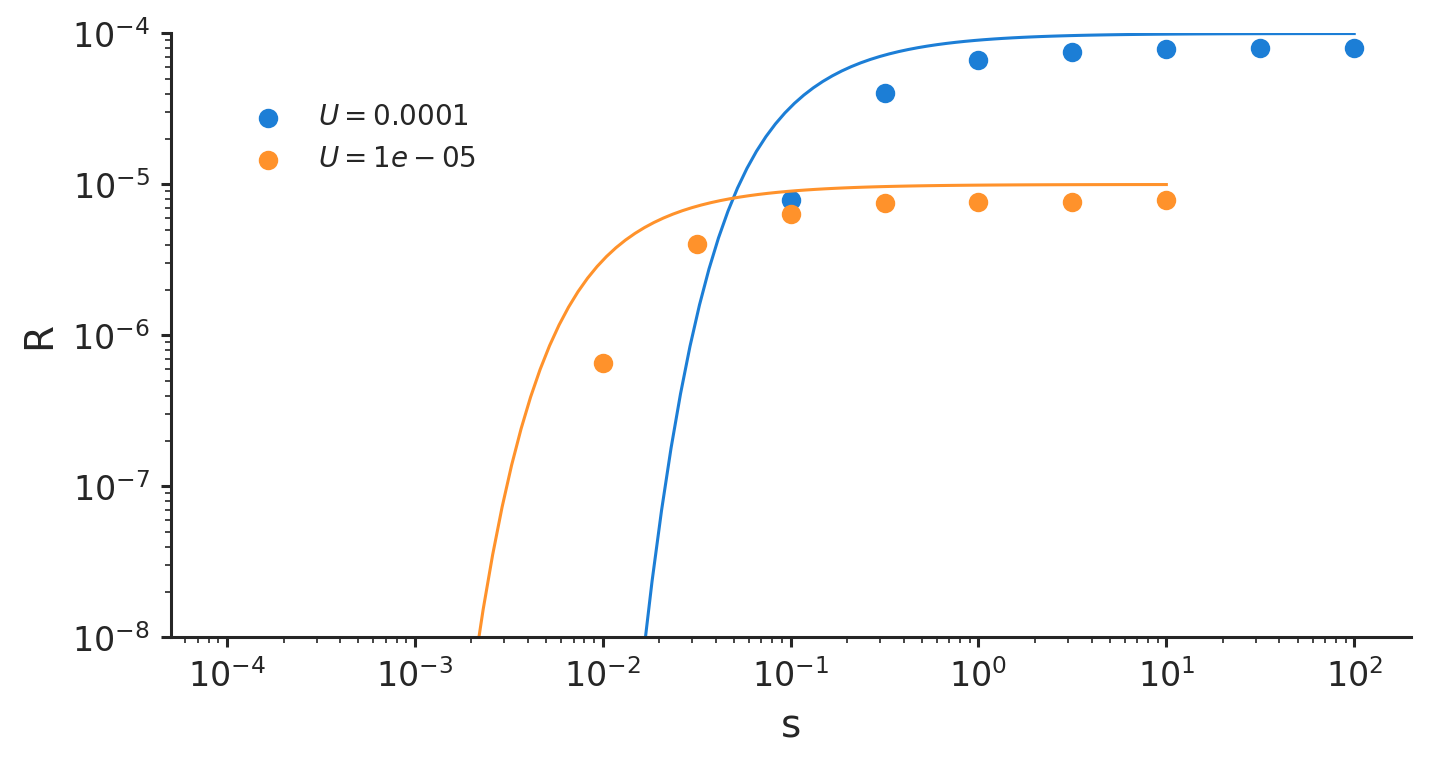

In [48]:
Us = [1e-4, 1e-5]

for U in Us:
    #plt.plot(sh, 2*(U * sh - sh/bgs_segment_sc16(U, sh, 1, rf, N, return_both=True)[0]))
    vga = vg.loc[vg['U'] == U]
    plt.scatter(U/vga['sh'], vga['R'], label=f"$U = {U}$")
    #plt.plot(sh, 2*(U * sh - sh/bgs_segment_sc16(U, sh, 1, rf, N, return_both=True)[0]))
    lines = plt.plot(U/sh, 1/bgs_segment_sc16(U, sh, 1, 1e-9, 1000, return_both=True)[0])
    
    R = vga['R'].values
    s = vga['sh'].values
    idx = np.argsort(s)
    s, R = s[idx], R[idx]
    T = 1/R
    #plt.plot(s, R, c=lines[0].get_color(), linestyle='dashed')
    
plt.ylabel("R")
plt.xlabel("s")
plt.legend()
plt.loglog()
plt.ylim(1e-8, 1e-4)

## Fixation Times and the Ratchet

In the strong BGS limit, the ratchet does not click, and fixation times $T \to \infty$. Under neutrality, the probability that a new neutral mutation fixes is $1/2N$, and $U$ of these enter the region each generation; the ratchet clicks with rate $U$. In S&C 1998, 

$$
Ne = N \exp\left(\frac{-2U}{2s+L}\left(1-\frac{1}{TU}\right)^3\right)
$$

As $R = 1/T \to U$, the cubic term goes to 0, and $N_e = N$ as expected under neutrality.

/home/vsb/projects/bprime/bgspy/theory.py:75: RuntimeWarning: overflow encountered in exp
  def func(x):
/home/vsb/projects/bprime/bgspy/theory.py:85: RuntimeWarning: overflow encountered in exp
  np.log(N * np.exp(-V*Q2)) - np.log(Ne)]
/home/vsb/projects/bprime/bgspy/theory.py:85: RuntimeWarning: invalid value encountered in double_scalars
  np.log(N * np.exp(-V*Q2)) - np.log(Ne)]
/home/vsb/projects/bprime/bgspy/theory.py:99: UserWarning: no solution found!
  return np.nan
/tmp/ipykernel_75194/540151236.py:14: RuntimeWarning: divide by zero encountered in true_divide
  T = 1/R
/home/vsb/projects/bprime/bgspy/theory.py:75: RuntimeWarning: overflow encountered in exp
  def func(x):
/home/vsb/projects/bprime/bgspy/theory.py:85: RuntimeWarning: overflow encountered in exp
  np.log(N * np.exp(-V*Q2)) - np.log(Ne)]
/home/vsb/projects/bprime/bgspy/theory.py:85: RuntimeWarning: invalid value encountered in double_scalars
  np.log(N * np.exp(-V*Q2)) - np.log(Ne)]
/home/vsb/projects/bprime/bgsp

(2e-06, 0.1)

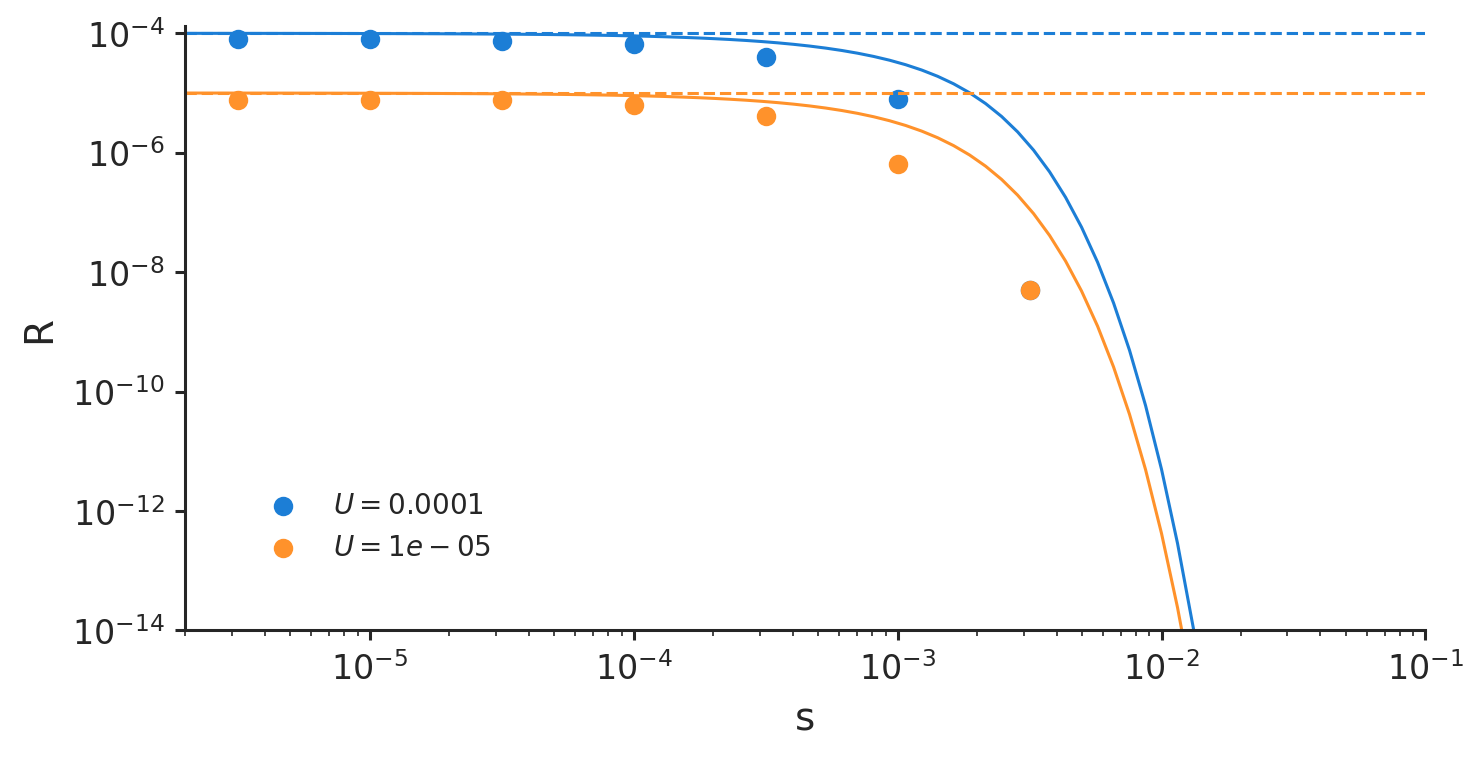

In [493]:
Us = [1e-4, 1e-5]

for U in Us:
    #plt.plot(sh, 2*(U * sh - sh/bgs_segment_sc16(U, sh, 1, rf, N, return_both=True)[0]))
    vga = vg.loc[vg['U'] == U]
    plt.scatter(vga['sh'], vga['R'], label=f"$U = {U}$")
    #plt.plot(sh, 2*(U * sh - sh/bgs_segment_sc16(U, sh, 1, rf, N, return_both=True)[0]))
    lines = plt.plot(sh, 1/bgs_rec_sc16(U, sh, 1, 1e-9, 1000, Q_segment=True, return_both=True)[0])
    
    R = vga['R'].values
    s = vga['sh'].values
    idx = np.argsort(s)
    s, R = s[idx], R[idx]
    T = 1/R
    #plt.plot(s, R, c=lines[0].get_color(), linestyle='dashed')
    plt.axhline(U, c=lines[0].get_color(), linestyle='dashed')
    
plt.ylabel("R")
plt.xlabel("s")
plt.legend()
plt.loglog()
plt.ylim(1e-14, 1.3e-4)
plt.xlim(2e-6, 1e-1)

## Fixation Time Interpolation

Fixation time is basically invariant with respect to $r_\mathrm{BP}$:

[]

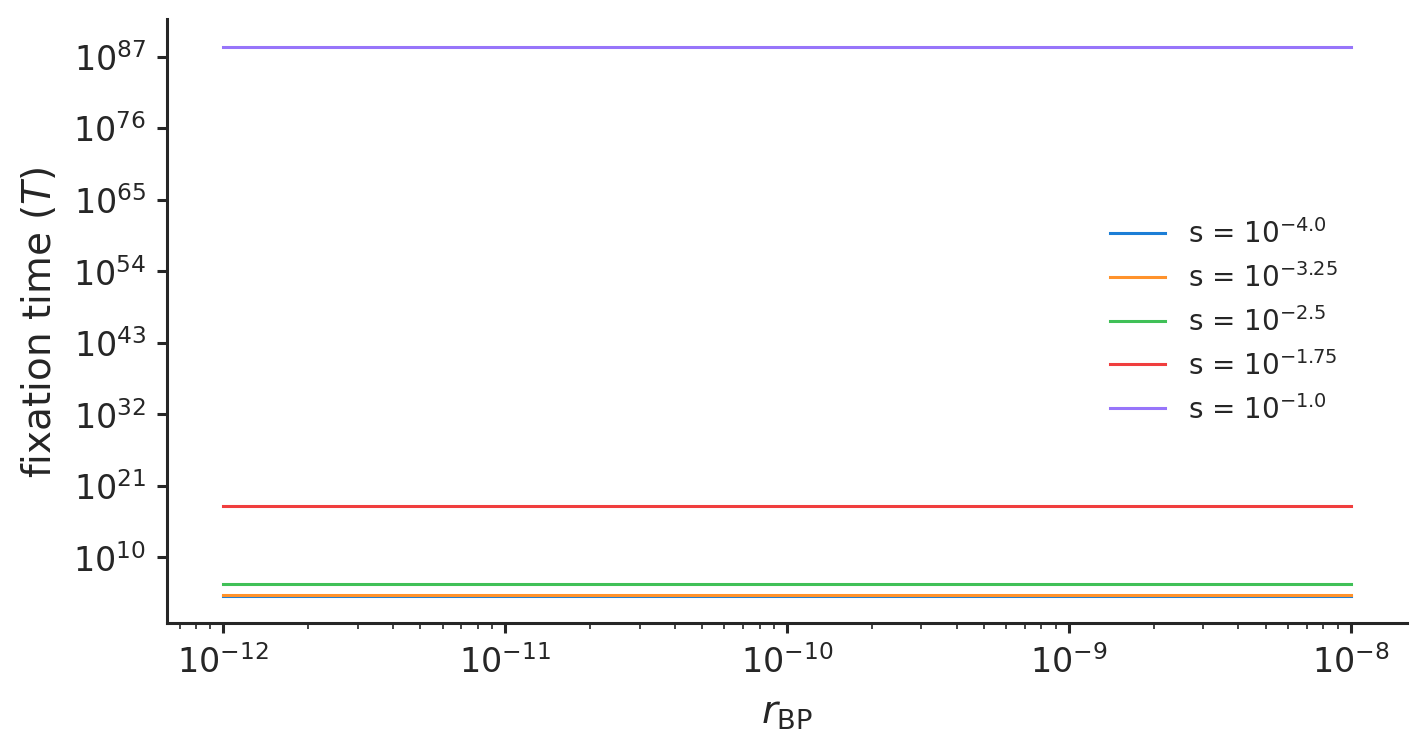

In [109]:
rbp = np.logspace(-12, -8, 100)

for s in np.logspace(-4, -1, 5):
    Ts = bgs_rec_sc16(1e-8, s, 10000, rbp, 1000, return_both=True)[0]
    plt.plot(rbp, Ts, label=f"s = $10^{{{np.log10(s)}}}$")

plt.ylabel("fixation time ($T$)")
plt.xlabel("$r_\mathrm{BP}$")
plt.legend()     
plt.loglog()

In [232]:
mu = np.logspace(-9, -8, 11)
sh = np.logspace(-4, -1, 13)
L = np.linspace(1, 10_000, 10)
N = 1000
T_grid = bgs_segment_sc16_grid(mu, sh, L, N, fixed_rbp=1e-8, value='T')

Us = np.multiply.outer(mu, sh)
U_min, U_max = Us.min(), Us.max()
U = np.logspace(np.log10(U_min), np.log10(U_max), 10)
T_grid_alt = bgs_segment_sc16_grid_alt(U, sh, N, fixed_rbp=1e-8, value='T')

In [170]:
T_grid_alt.shape

(10, 13)

In [174]:
T_grid_alt[:, i].shape

(10,)

(10.0, 10000.0)

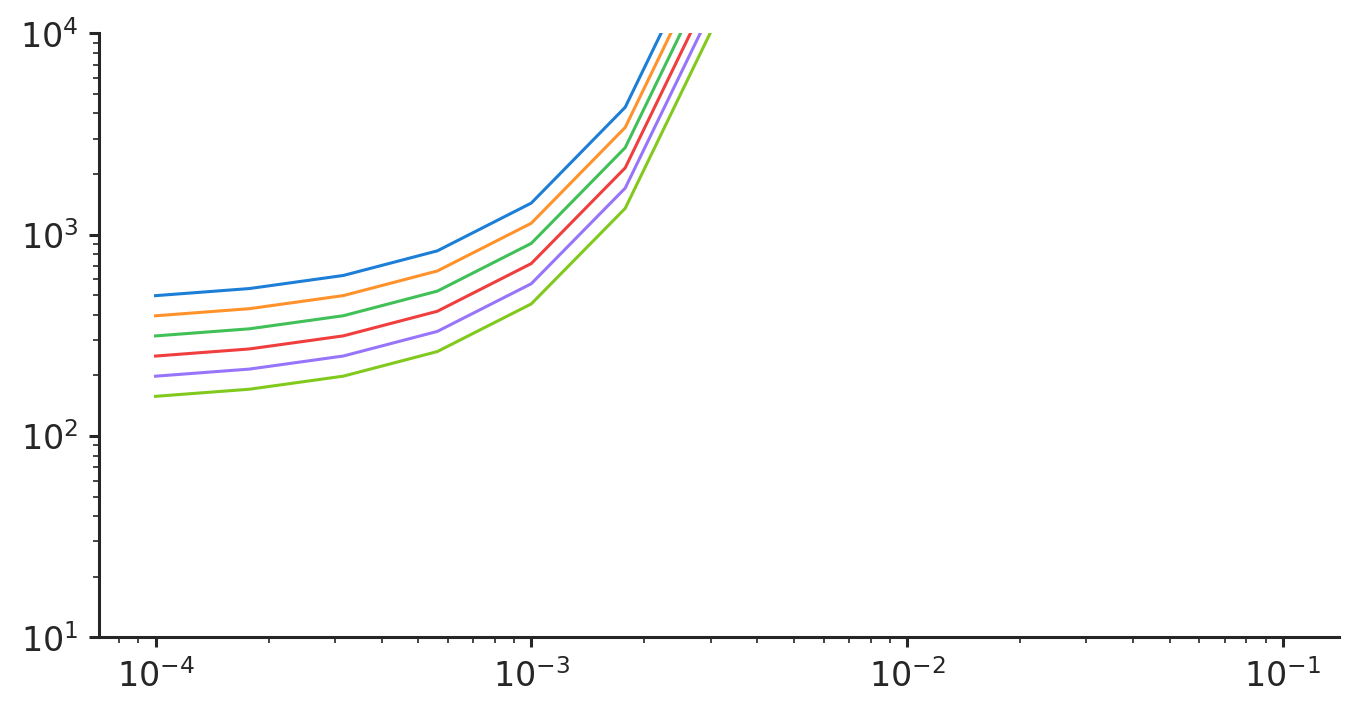

In [175]:
for i, _ in enumerate(mu[::2]):
    plt.plot(sh, T_grid[i, :, 2].squeeze())

plt.loglog()
plt.ylim(1e1, 1e4)

In [281]:
def simple_T(U, sh, N):
    ""
    T = (np.exp(2*sh*N) - 1)/(2*U*sh*N)
    return T

In [302]:
mu = np.logspace(-9, -8, 11)
sh = np.logspace(-4, -1, 13)

#L = 10_000
N = 1000
ll = []
ss = []
mm = []
Ts = []
T_alts = []
T_simps = []

for l in [10, 100, 10_000]:#[1e-7, 1e-8, 1e-10]:
    for m in mu:
        for s in sh:
            Ts.append(bgs_rec_sc16(m, s, l, r, N, return_both=True)[0])
            U = m*l
            T_alts.append(bgs_rec_sc16_alt(U, s, r, N, return_both=True)[0])
            T_simps.append(simple_T(U, s, N))
            ss.append(s)
            mm.append(m)
            ll.append(l)
            
Ts = np.array(Ts)
T_alts = np.array(T_alts)
T_simps = np.array(T_simps)

Text(0.5, 0, 'T under full model with μ and L')

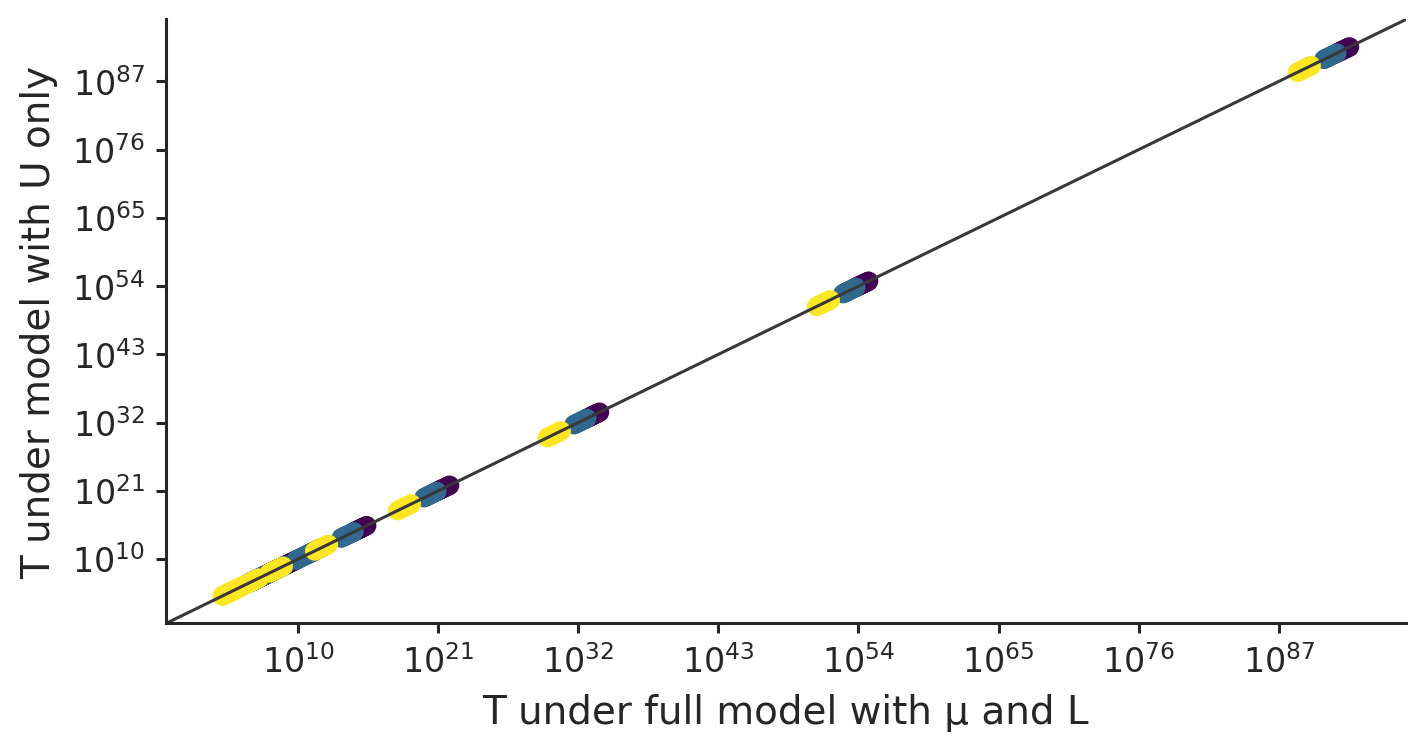

In [287]:
plt.axline((0, 0), slope=1, c='0.22')
plt.scatter(Ts, T_alts, c=np.log10(ll))
plt.loglog()
plt.ylabel('T under model with U only')
plt.xlabel('T under full model with μ and L')

Text(0.5, 0, 'T for full model with μ and L')

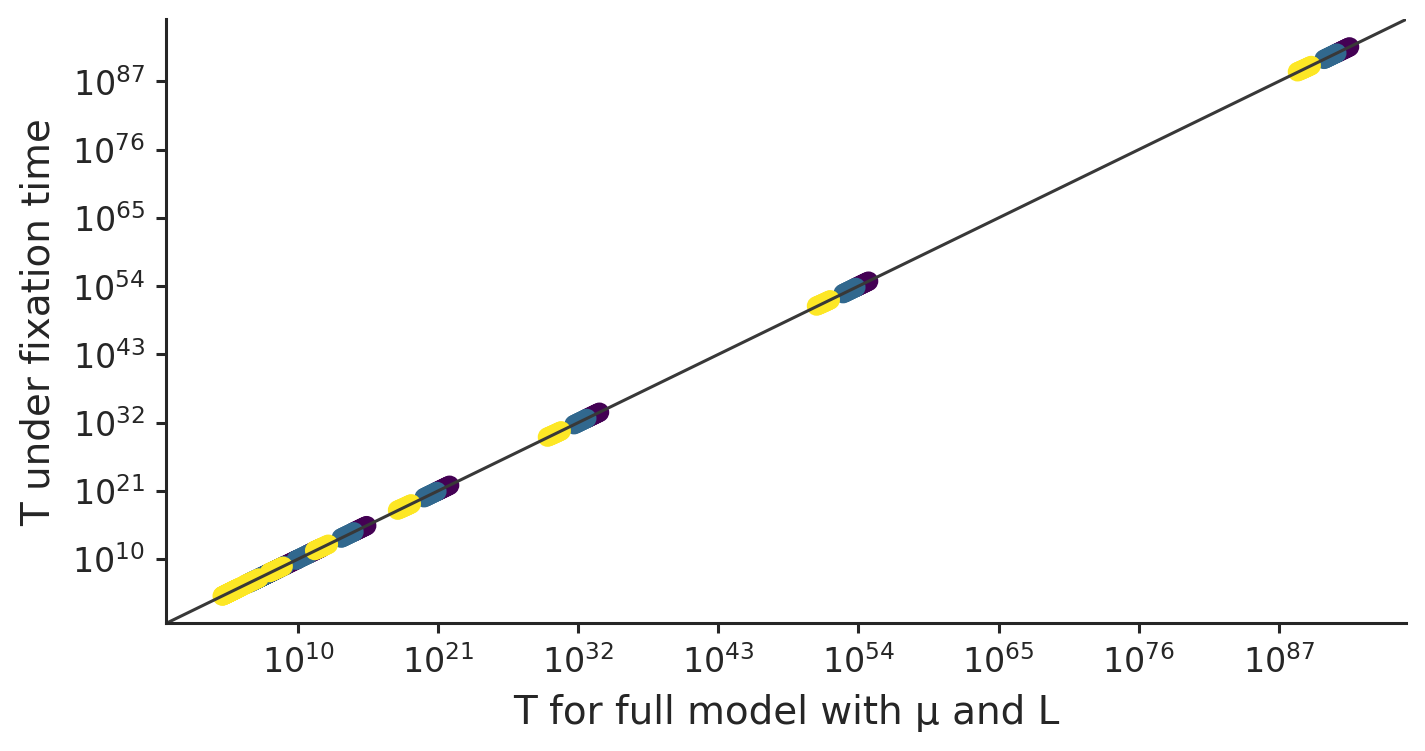

In [288]:
plt.axline((0, 0), slope=1, c='0.22')
plt.scatter(Ts, T_simps, c=np.log10(ll))
plt.loglog()
plt.ylabel('T under fixation time')
plt.xlabel('T for full model with μ and L')

Text(0.5, 0, 'sh')

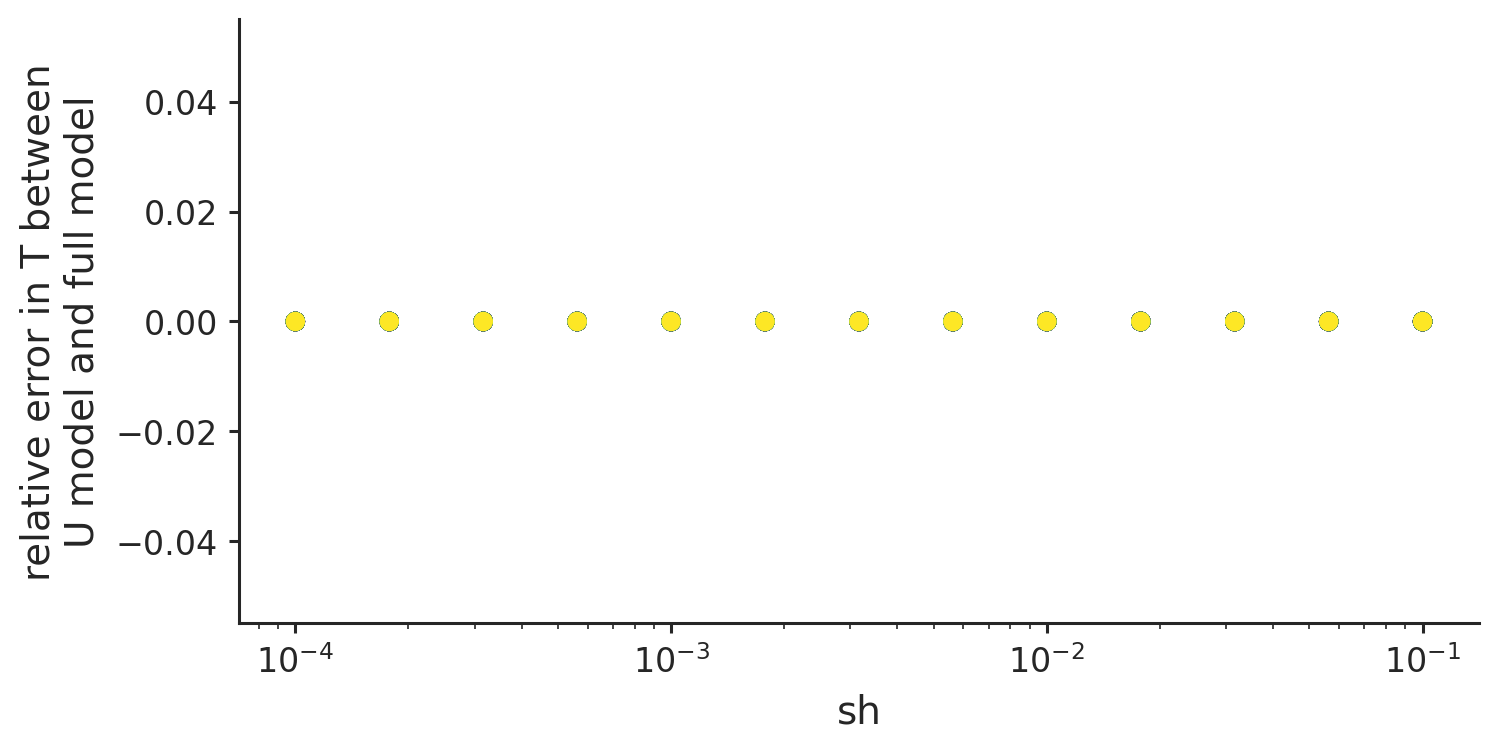

In [380]:
plt.scatter(ss, rel_error(T_alts, Ts), c=mm)
plt.semilogx()
plt.ylabel("relative error in T between\nU model and full model")
plt.xlabel("sh")

Text(0.5, 0, 'sh')

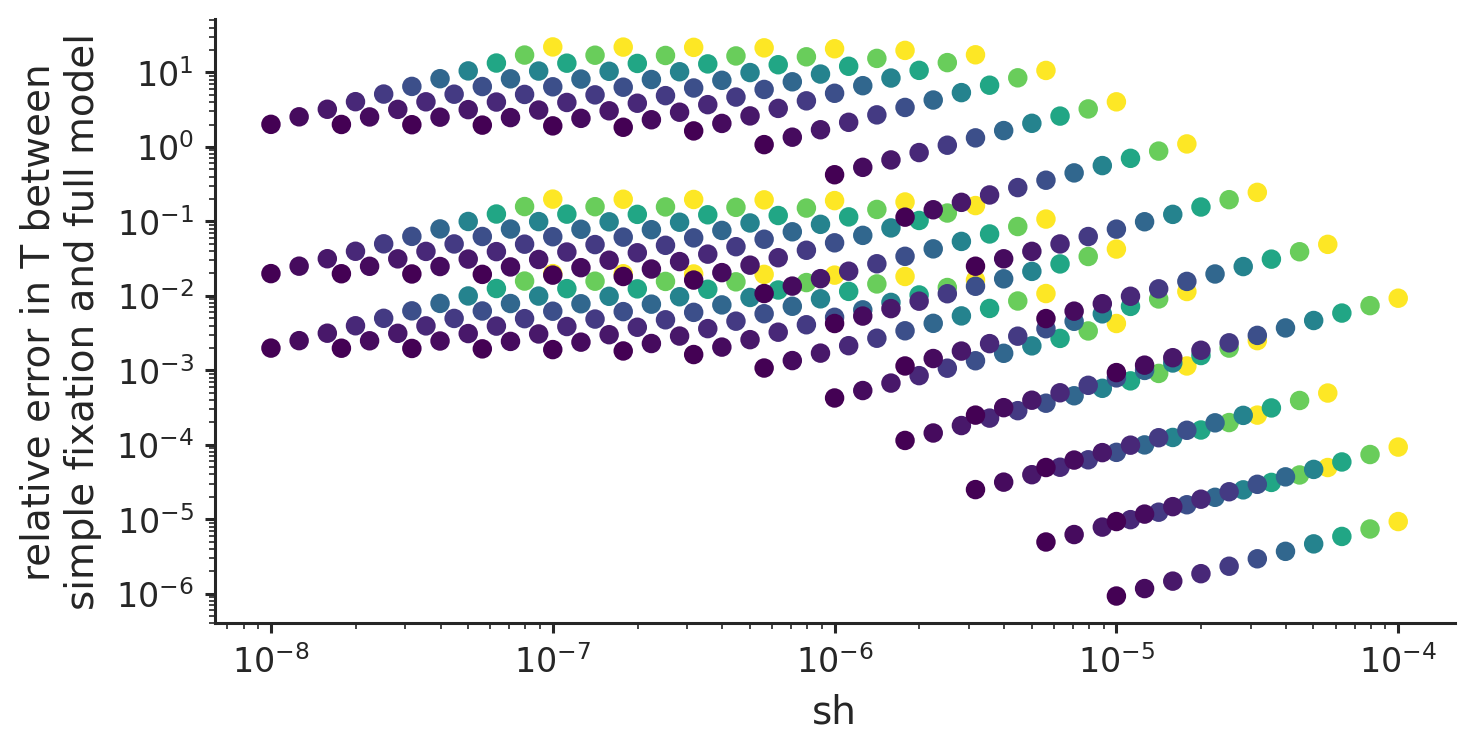

In [383]:
plt.scatter(np.array(mm)/np.array(ss), rel_error(T_simps, Ts), c=mm)
plt.loglog()
plt.ylabel("relative error in T between\nsimple fixation and full model")
plt.xlabel("sh")

[]

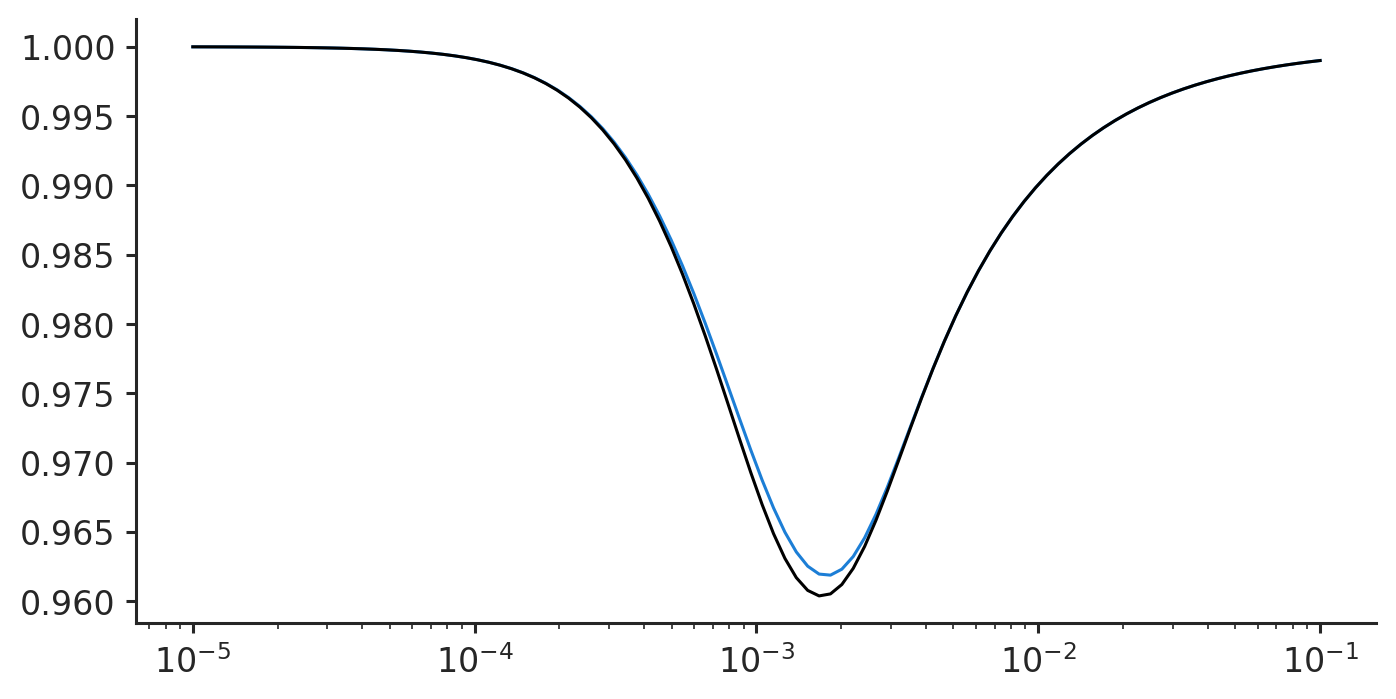

In [273]:
mu = 1e-8
N = 1000
L = 10000
r = 1e-8


def simple(mu, sh, L, r, N):
    U = L*mu
    T = (np.exp(2*sh*N) - 1)/(2*U*sh*N)
    Vm = U*sh**2
    V = U*sh - sh/T
    Q2 = (1/((Vm/V) + r))**2
    return N * np.exp(-V*Q2)

sh = np.logspace(-5, -1, 100)
plt.plot(sh, bgs_rec_sc16(mu, sh, L, r, N)/N)


plt.plot(sh, simple(mu, sh, L, r, N)/N, c='k')
plt.semilogx()

How does the rf approximation work? This was done in Mathematica, taking an integral over the segment length a fixed recombination fraction away.

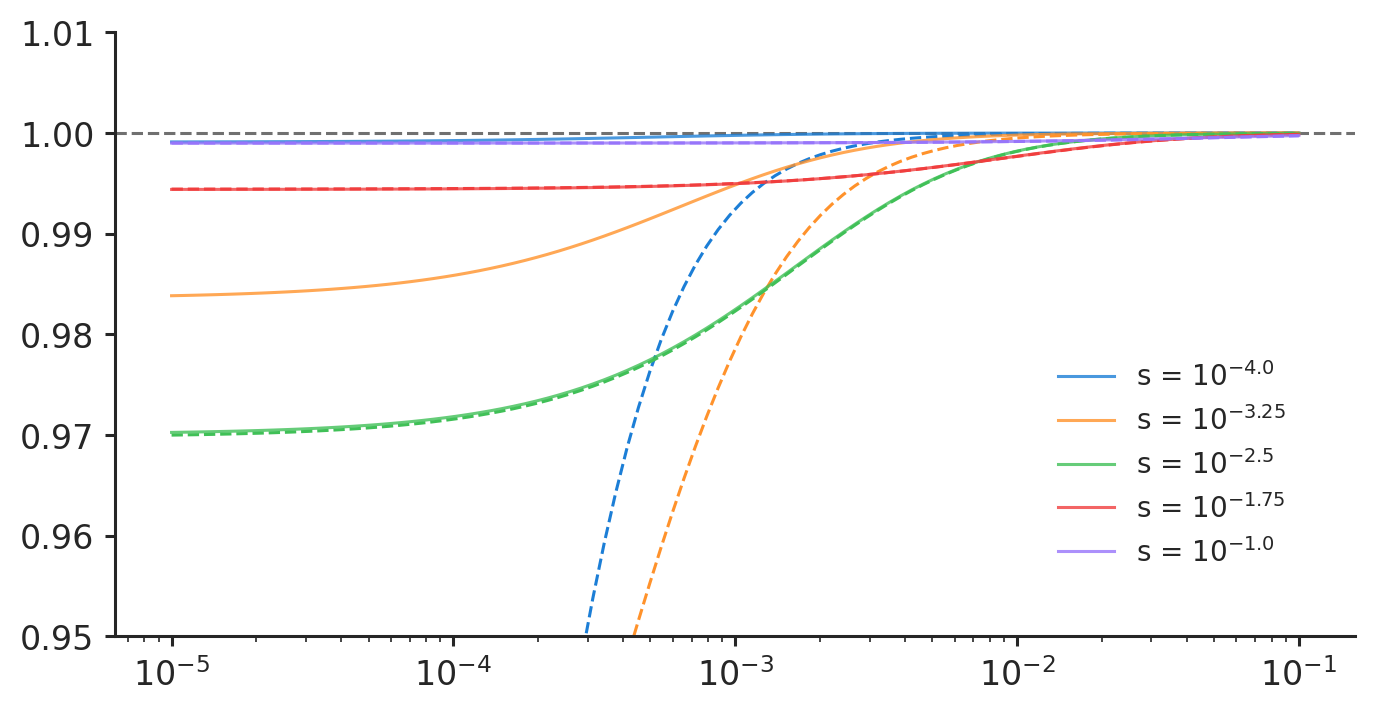

In [384]:
rf = np.logspace(-5, -1, 100)

sels = np.logspace(-4, -1, 5)

for s in sels:
    #lines = plt.plot(rf, bgs_segment_sc16(1e-8, s, 10_000, 1e-8, rf, 1000)/1000, label=f"s = $10^{{{np.log10(s)}}}$")
    lines = plt.plot(rf, bgs_rec_sc16(1e-8, s, 10_000, rf, 1000)/1000, label=f"s = $10^{{{np.log10(s)}}}$", alpha=0.8)
    col = lines[0].get_color()
    plt.plot(rf, bgs_segment(1e-8, s, 10_000, 1e-8, rf), linestyle='dashed', c=col)
plt.axhline(1, linestyle='dashed', c='0.44', zorder=-1)
plt.semilogx()
plt.ylim(0.95, 1.01)
plt.legend()

This model (commented out) does poorly. TODO remove

In [313]:
bgs_segment_sc16(1e-8, 1e-4, 10_000, 1e-8, 1e-1, 1000)

(array([11069.05624189,   999.05433587]),
 array({'nfev': 6, 'fjac': array([[-0.9999583 , -0.00913217],
        [ 0.00913217, -0.9999583 ]]), 'r': array([ 9.03370212e-05, -9.41716660e-05,  1.00183679e-03]), 'qtf': array([5.49991864e-12, 2.11448972e-10]), 'fvec': array([1.77635684e-15, 0.00000000e+00])},
       dtype=object),
 array(1),
 array('The solution converged.', dtype='<U23'))

ERROR! Session/line number was not unique in database. History logging moved to new session 1468


In [18]:
Us = [1e-4, 1e-5]

for U in Us:
    #plt.plot(sh, 2*(U * sh - sh/bgs_segment_sc16(U, sh, 1, rf, N, return_both=True)[0]))
    vga = vg.loc[vg['U'] == U]
    plt.scatter(vga['R'], vga['y'], label=f"$U = {U}$")

    
plt.ylabel("B")
plt.xlabel("R")
plt.legend()
plt.semilogx()

NameError: name 'vg' is not defined

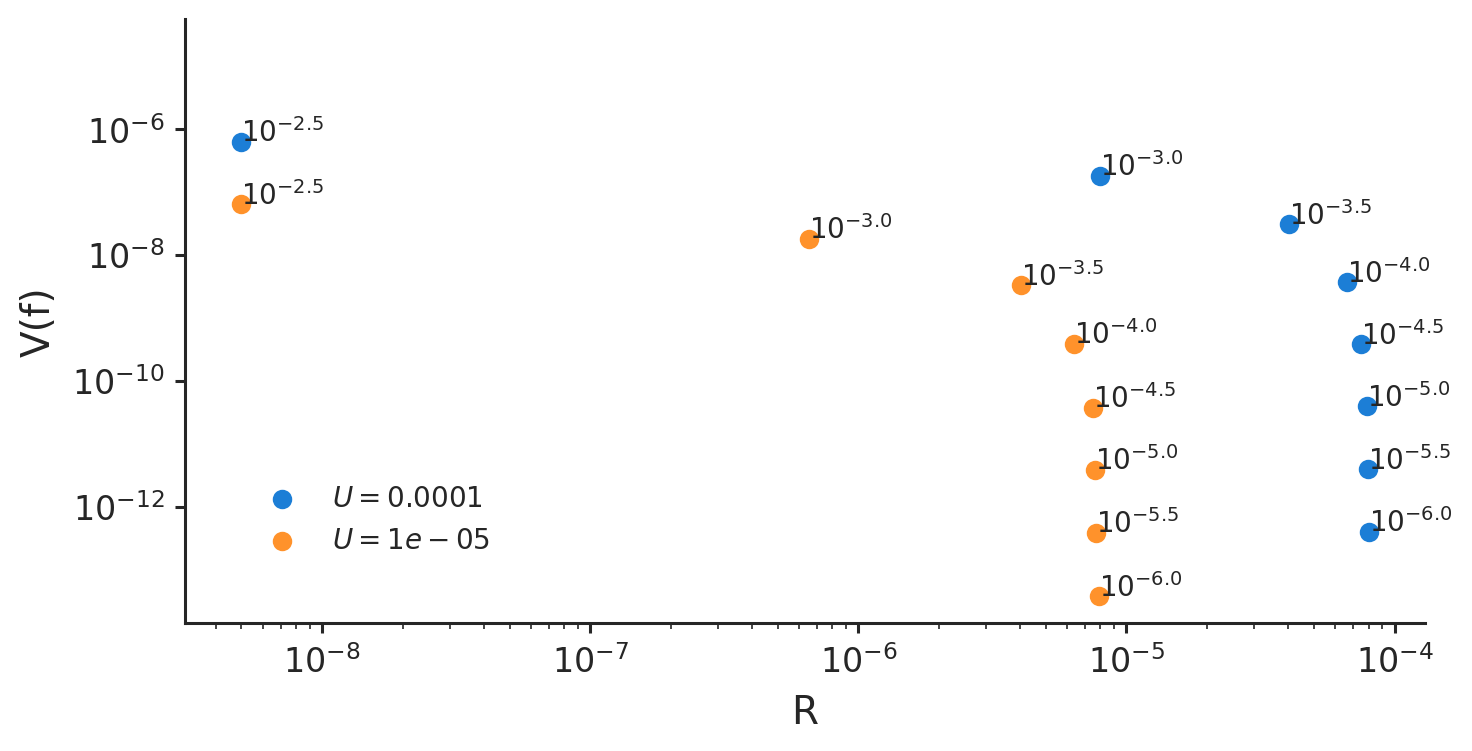

In [60]:
sh = np.logspace(-5, -0.00001, 100)

rf = 1e-8
Us = [1e-4, 1e-5]
N = 1000

for U in Us:
    vga = vg.loc[vg['U'] == U]
    plt.scatter(vga['R'], vga['Vf'], label=f"$U = {U}$")
    R = vga['R'].values
    Vf = vga['Vf'].values
    sh = vga['sh'].values
    for i in range(vga['R'].size):
        plt.annotate(f"$10^{{{np.round(np.log10(sh[i]), 3)}}}$", (R[i], Vf[i]))
plt.loglog()
plt.ylabel("V(f)")
plt.xlabel("R")
plt.legend()

/home/vsb/projects/bprime/bgspy/theory.py:45: RuntimeWarning: overflow encountered in exp
  start_T = (np.exp(2*sh*N) - 1)/(2*U*sh*N)
/home/vsb/projects/bprime/bgspy/theory.py:55: RuntimeWarning: overflow encountered in exp
  return [np.log((np.exp(2*sh*Ne) - 1)/(2*U*sh*Ne)) - np.log(T),
/home/vsb/projects/bprime/bgspy/theory.py:55: RuntimeWarning: invalid value encountered in double_scalars
  return [np.log((np.exp(2*sh*Ne) - 1)/(2*U*sh*Ne)) - np.log(T),
/home/vsb/projects/bprime/bgspy/theory.py:69: UserWarning: no solution found!
  return np.nan
/tmp/ipykernel_75194/2887121203.py:14: RuntimeWarning: divide by zero encountered in true_divide
  T = 1/R
/home/vsb/projects/bprime/bgspy/theory.py:45: RuntimeWarning: overflow encountered in exp
  start_T = (np.exp(2*sh*N) - 1)/(2*U*sh*N)
/home/vsb/projects/bprime/bgspy/theory.py:55: RuntimeWarning: overflow encountered in exp
  return [np.log((np.exp(2*sh*Ne) - 1)/(2*U*sh*Ne)) - np.log(T),
/home/vsb/projects/bprime/bgspy/theory.py:55: Runt

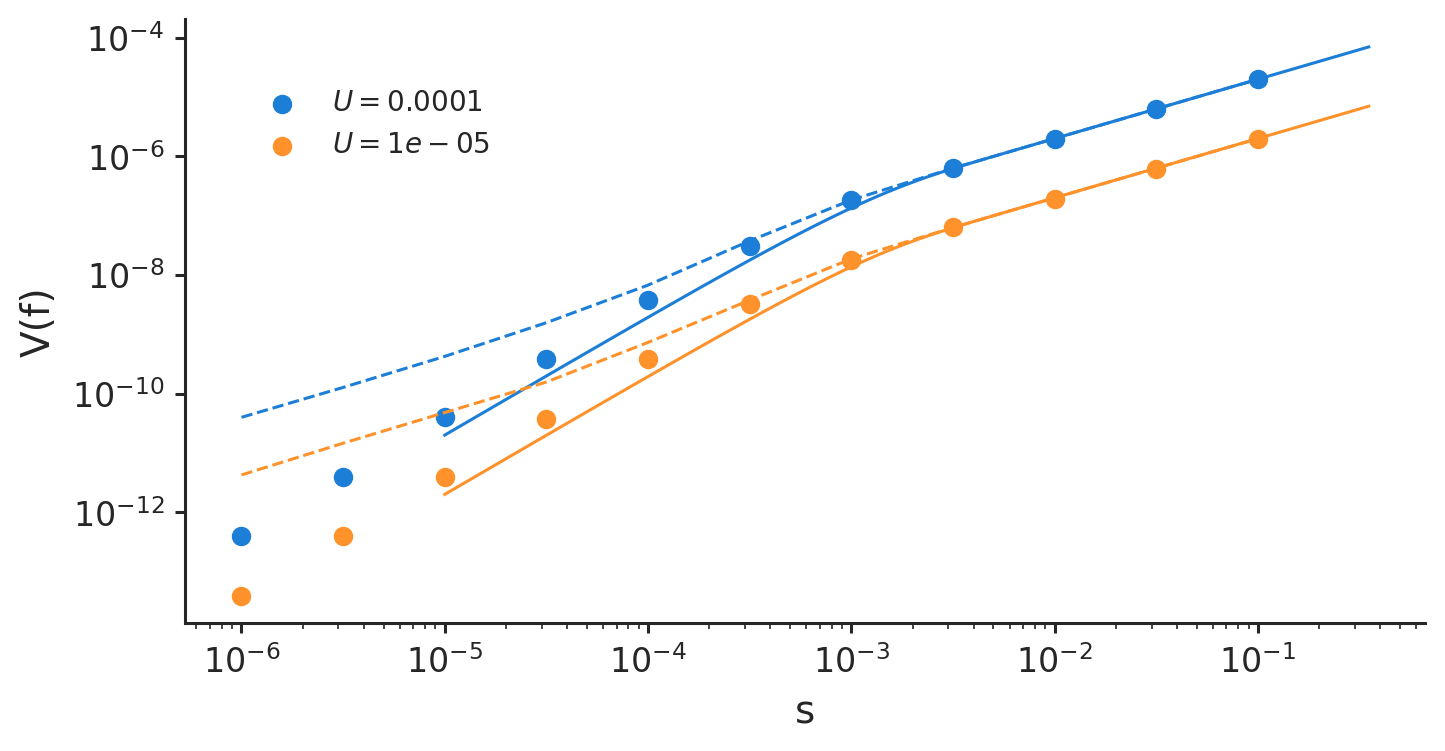

In [393]:
sh = np.logspace(-5, -0.00001, 100)

rf = 1e-8
Us = [1e-4, 1e-5]
N = 1000

for U in Us:
    lines = plt.plot(sh, 2*(U * sh - sh/bgs_segment_sc16(U, sh, 1, rf, N, return_both=True)[0]))
    vga = vg.loc[vg['U'] == U]
    R = vga['R'].values
    s = vga['sh'].values
    idx = np.argsort(s)
    s, R = s[idx], R[idx]
    T = 1/R
    plt.plot(s, 2*(U * s - s/T), c=lines[0].get_color(), linestyle='dashed')
    plt.scatter(vga['sh'], vga['Vf'], label=f"$U = {U}$")

plt.loglog()
plt.ylabel("V(f)")
plt.xlabel("s")
plt.legend()

/home/vsb/projects/bprime/bgspy/theory.py:45: RuntimeWarning: overflow encountered in exp
  start_T = (np.exp(2*sh*N) - 1)/(2*U*sh*N)
/home/vsb/projects/bprime/bgspy/theory.py:55: RuntimeWarning: overflow encountered in exp
  return [np.log((np.exp(2*sh*Ne) - 1)/(2*U*sh*Ne)) - np.log(T),
/home/vsb/projects/bprime/bgspy/theory.py:55: RuntimeWarning: invalid value encountered in double_scalars
  return [np.log((np.exp(2*sh*Ne) - 1)/(2*U*sh*Ne)) - np.log(T),
/home/vsb/projects/bprime/bgspy/theory.py:69: UserWarning: no solution found!
  return np.nan
/home/vsb/projects/bprime/bgspy/theory.py:45: RuntimeWarning: overflow encountered in exp
  start_T = (np.exp(2*sh*N) - 1)/(2*U*sh*N)
/home/vsb/projects/bprime/bgspy/theory.py:55: RuntimeWarning: overflow encountered in exp
  return [np.log((np.exp(2*sh*Ne) - 1)/(2*U*sh*Ne)) - np.log(T),
/home/vsb/projects/bprime/bgspy/theory.py:55: RuntimeWarning: invalid value encountered in double_scalars
  return [np.log((np.exp(2*sh*Ne) - 1)/(2*U*sh*Ne))

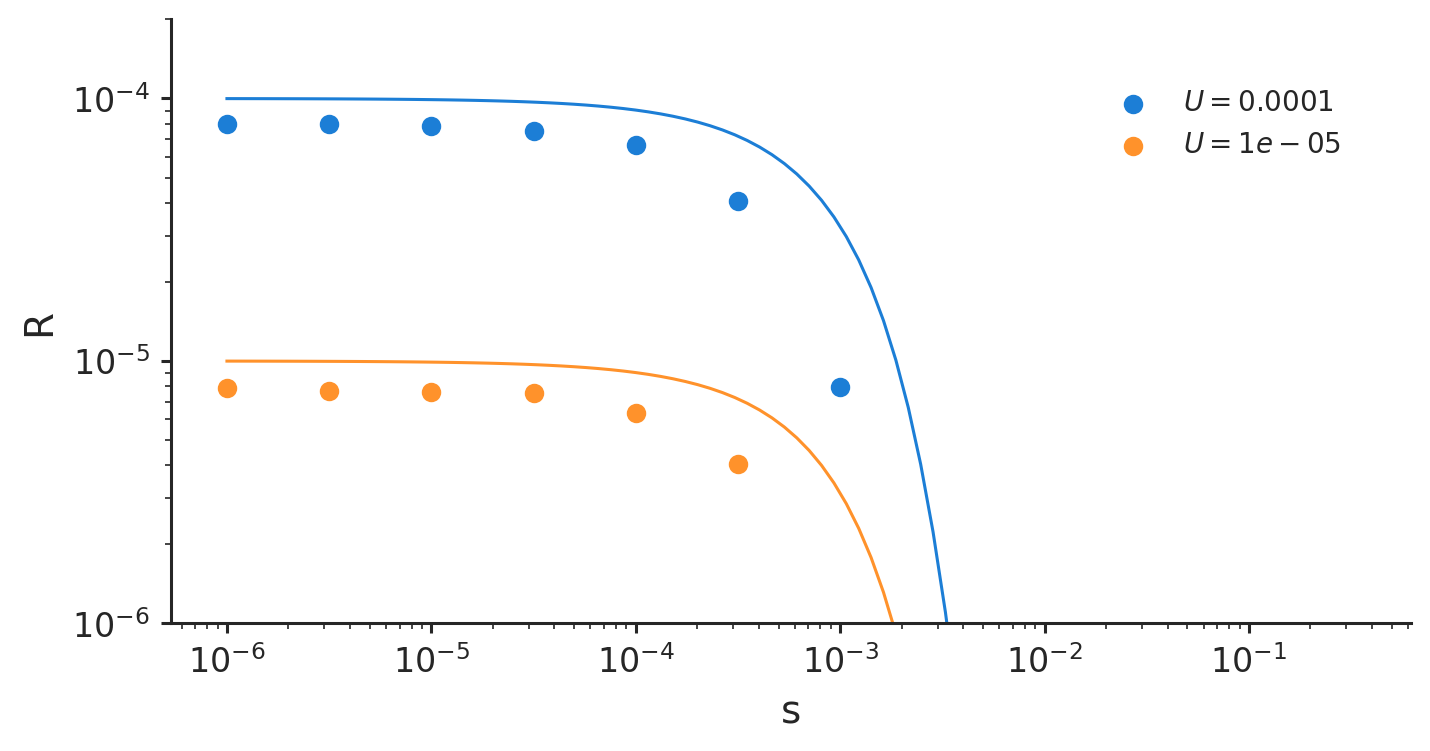

In [439]:
rf = 1e-8
Us = [1e-4, 1e-5]
N = 1000
sh = np.logspace(-6, -0.00001, 100)

plt.axhline(0, c='0.22', linestyle='dashed')
for U in Us:
    lines = plt.plot(sh, 1/bgs_segment_sc16(U, sh, 1, rf, N, return_both=True)[0])
    vga = vg.loc[vg['U'] == U]
    plt.scatter(vga['sh'], vga['R'], label=f"$U = {U}$")

plt.loglog()
plt.ylim(1e-6, 2e-4)
plt.ylabel("R")
plt.xlabel("s")
plt.legend()

/home/vsb/projects/bprime/bgspy/theory.py:45: RuntimeWarning: overflow encountered in exp
  start_T = (np.exp(2*sh*N) - 1)/(2*U*sh*N)
/home/vsb/projects/bprime/bgspy/theory.py:55: RuntimeWarning: overflow encountered in exp
  return [np.log((np.exp(2*sh*Ne) - 1)/(2*U*sh*Ne)) - np.log(T),
/home/vsb/projects/bprime/bgspy/theory.py:55: RuntimeWarning: invalid value encountered in double_scalars
  return [np.log((np.exp(2*sh*Ne) - 1)/(2*U*sh*Ne)) - np.log(T),
/home/vsb/projects/bprime/bgspy/theory.py:69: UserWarning: no solution found!
  return np.nan


[]

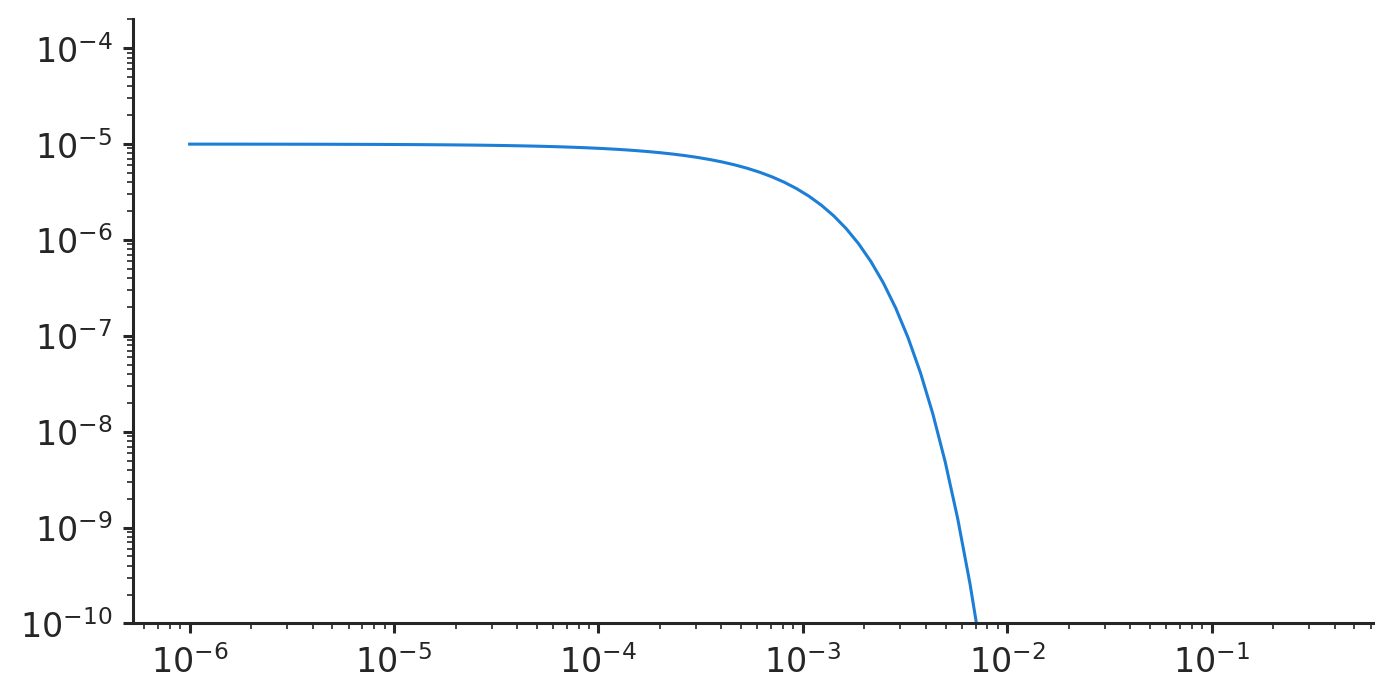

In [461]:
T = bgs_segment_sc16(1e-8, sh, 1000, 1e-8, 1000, return_both=True)[0]
idx = np.isfinite(T)
plt.plot(sh[idx], 1/T[idx])
plt.ylim(1e-10, 2e-4)
plt.loglog()

## Fit to simulation data

NameError: name 'vg' is not defined

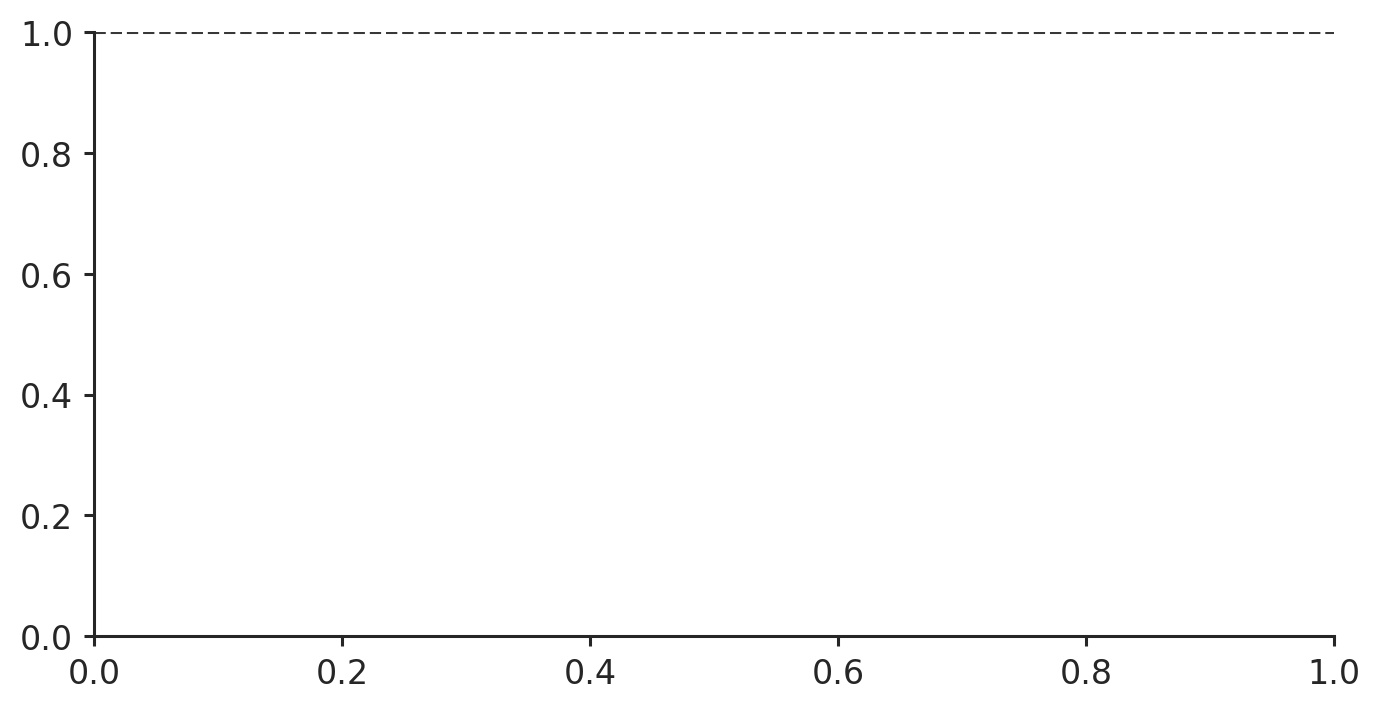

In [201]:
rf = 1e-9
rbp = 1e-8
Us = [1e-4, 1e-5]
N = 1000

plt.axhline(1, c='0.22', linestyle='dashed')
for U in Us:
    #lines = plt.plot(sh, 1/bgs_segment_sc16(U, sh, 1, rf, N, return_both=True)[0])
    vga = vg.loc[vg['U'] == U]
    plt.scatter(vga['sh'], vga['y'], label=f"$U = {U}$")
    sc16 = bgs_segment_sc16(U, sh, 1, rbp, rf, N)/N
    lines = plt.plot(sh, sc16)
    sc16_rec = bgs_rec_sc16(U, sh, 1, rf, N)
    plt.plot(sh, sc16_rec/N, c='g')
    
    sh_alt = np.logspace(-4, -1, 100)
    plt.plot(sh_alt, np.exp(-U/sh_alt), c=lines[0].get_color(), linestyle='dashed')
    
    sh = [1e-05, 3.16227766e-05, 1e-04, 3.16227766e-04, 0.0005623413251753778, 1e-03, 0.0017782794099915795, 3.16227766e-03, 0.005623413251753778, 1e-02, 3.16227766e-02, 1e-01]
    sh_new = sorted(set(sh + []))
    plt.scatter(sh, bgs_segment_sc16(U, sh, 1, rbp, rf, N)/N, c='k')
plt.ylim(0.95, 1.01)
plt.semilogx()

## Dimensionality Reduction

In [113]:
vd = load_validation('../data/slim_sims/validate_dim/validate_dim.npz')

# fix for annoying upstream bug 
vd['key'] = [k.replace('.json', '') for k in vd['key']]

vd_means = group_means(vd)

vd['muL'] = [str(signif(v, 2)) for v in vd['mu']*vd['L']]
vd = vd.sort_values(['muL'])

vd_means['muL'] = [str(signif(v, 2)) for v in vd_means['mu']*vd_means['L']]
vd_means = vd_means.sort_values(['muL'])

[]

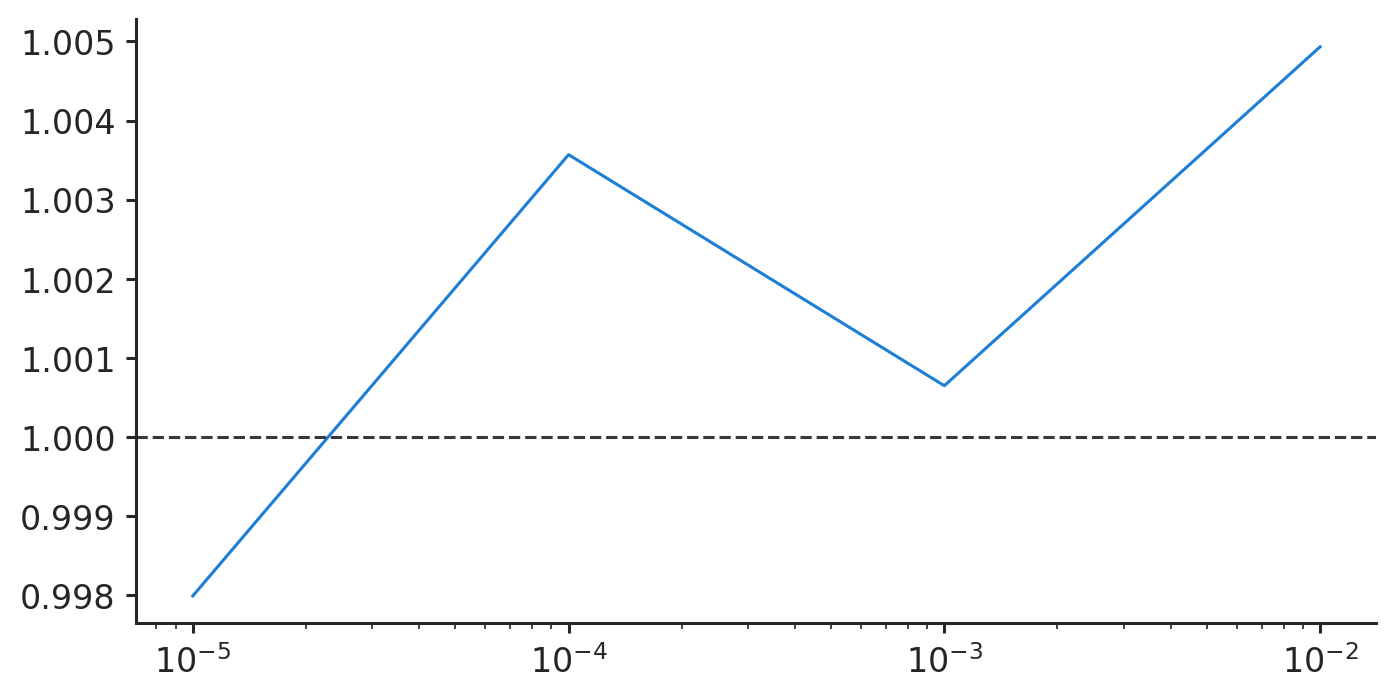

In [133]:
dd = group_means(vd.loc[(vd.mu == 1e-9) & (vd.L == 10_000)])

plt.plot(dd['sh'], dd['y'])
plt.axhline(1, linestyle='dashed', c='0.22')
plt.semilogx()

[]

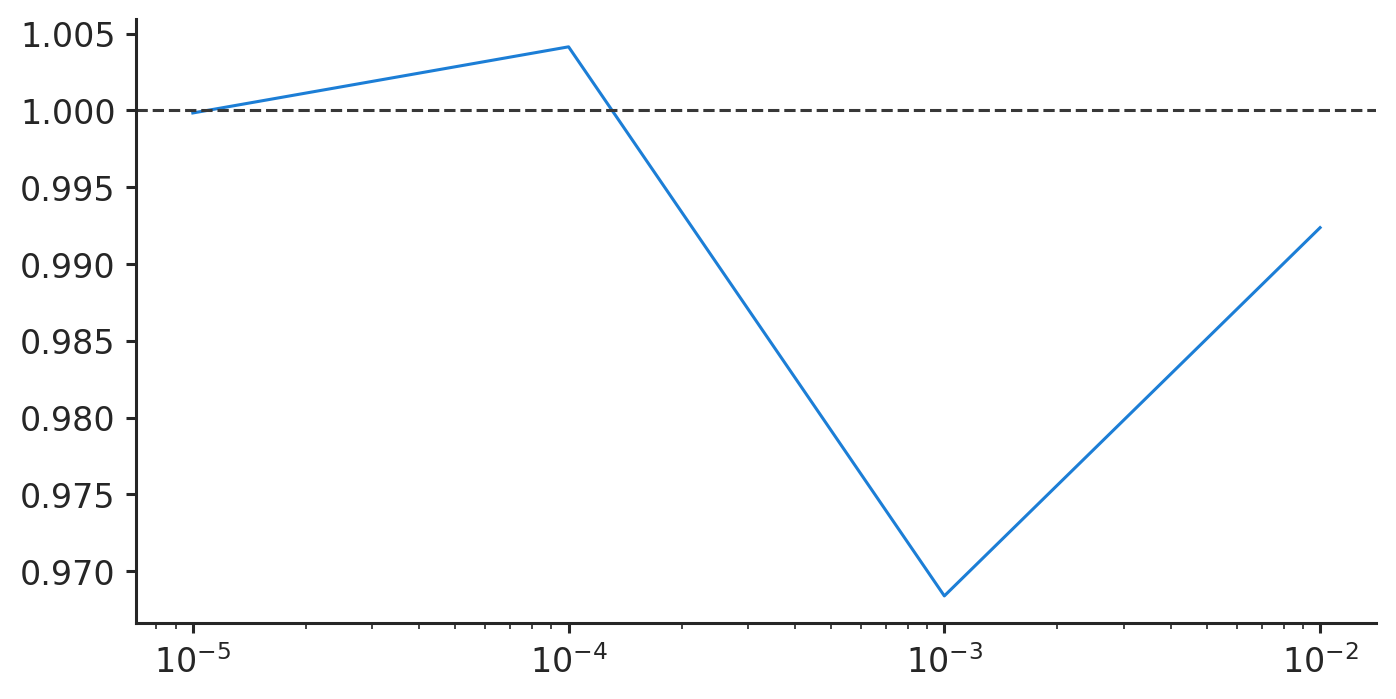

In [153]:
dd = group_means(vd.loc[(vd.mu == 1e-8) & (vd.L == 10_000)])

plt.plot(dd['sh'], dd['y'])
plt.axhline(1, linestyle='dashed', c='0.22')
plt.semilogx()

Using Chebychef, what are the error bounds?

Text(0.5, 0, 'ε')

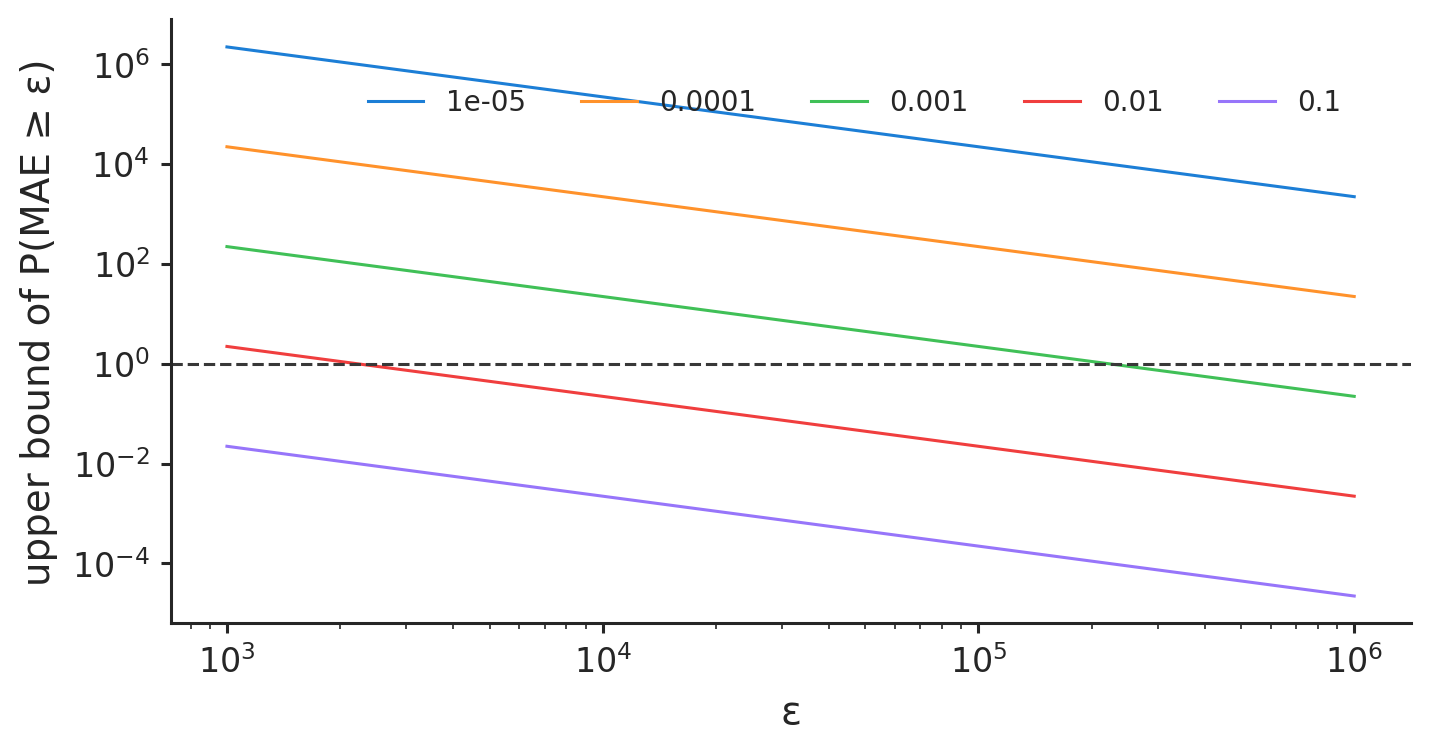

In [148]:
r = np.array([1000, 5000, 10_000, 50_000, 100_000, 1_000_000])
for eps in np.logspace(-5, -1, 5):
    plt.plot(r, 2/(9*r*eps**2), label=eps)
    plt.loglog()
plt.axhline(1, linestyle='dashed', c='0.22')
plt.legend(ncol=5)
plt.ylabel('upper bound of P(MAE ≥ ε)')
plt.xlabel('ε')

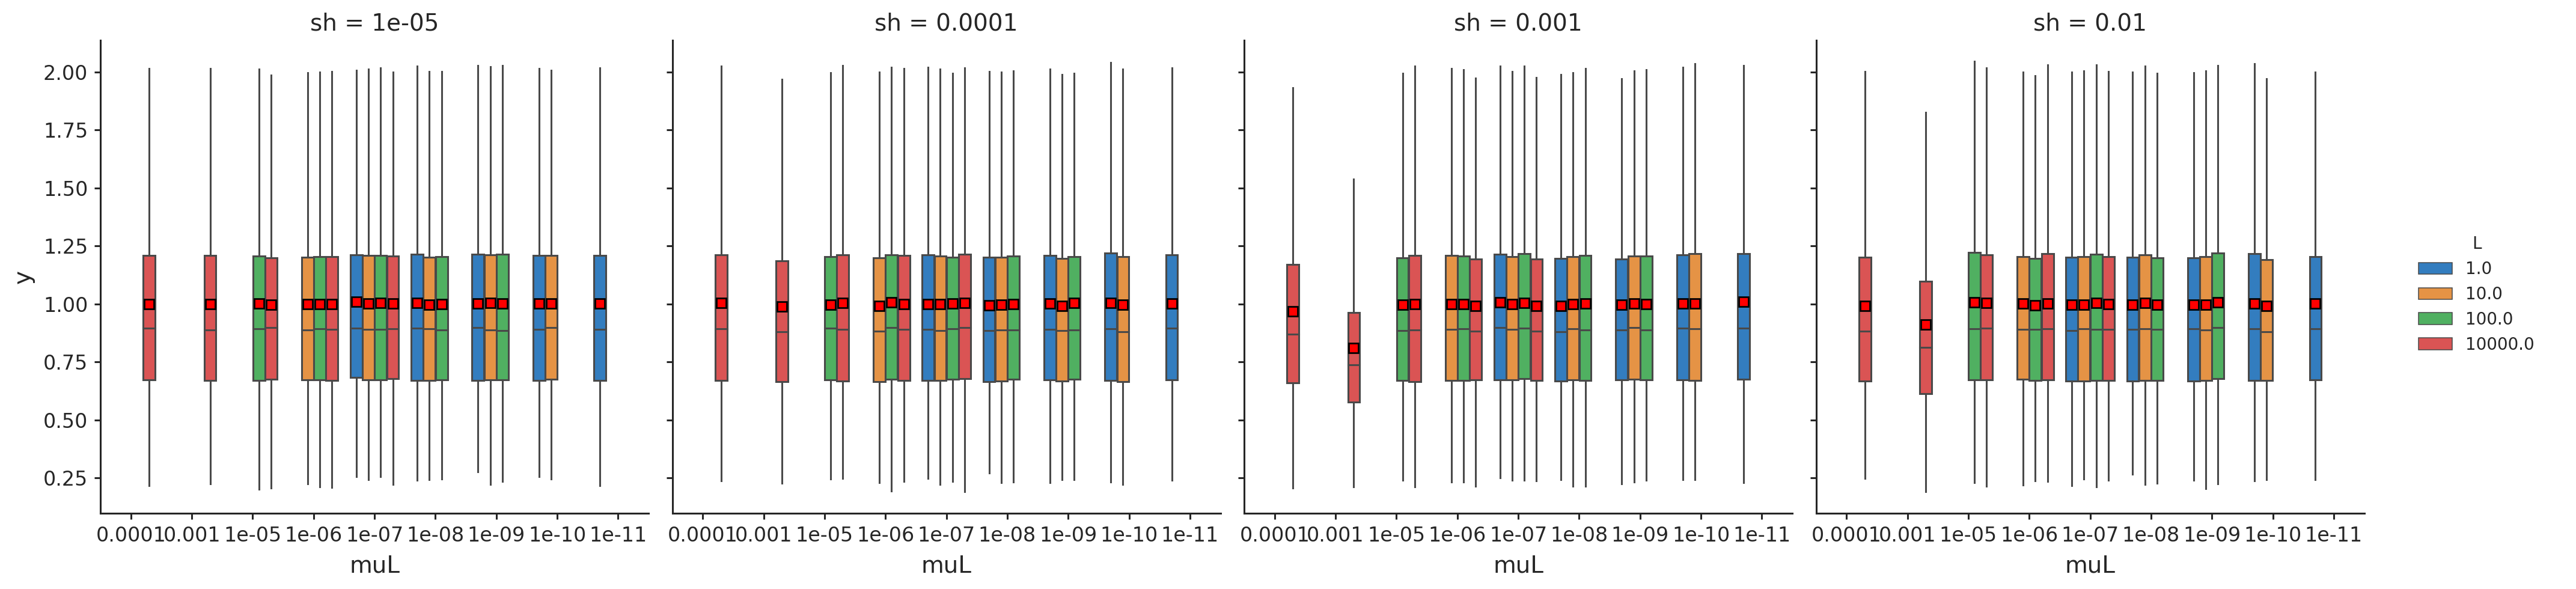

In [119]:
sns.catplot(x='muL', y='y', hue='L', data=vd, col='sh', kind='box', showmeans=True)

(0.95, 1.03)

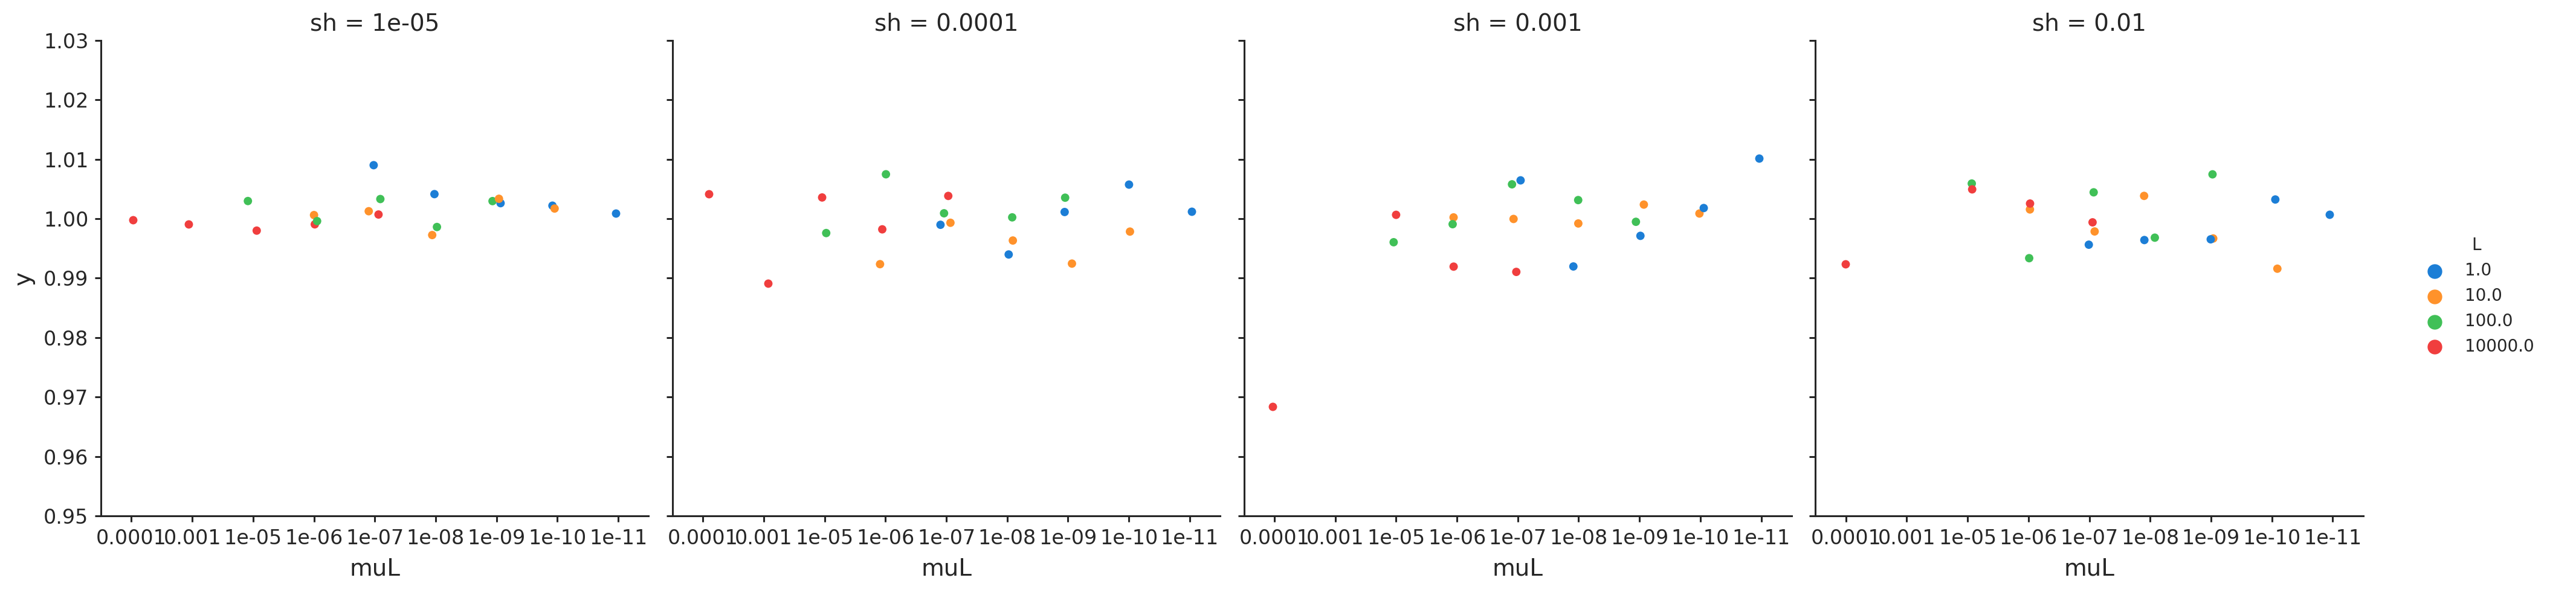

In [120]:
sns.catplot(x='muL', y='y', hue='L', data=vd_means, col='sh')
plt.ylim(0.95, 1.03)

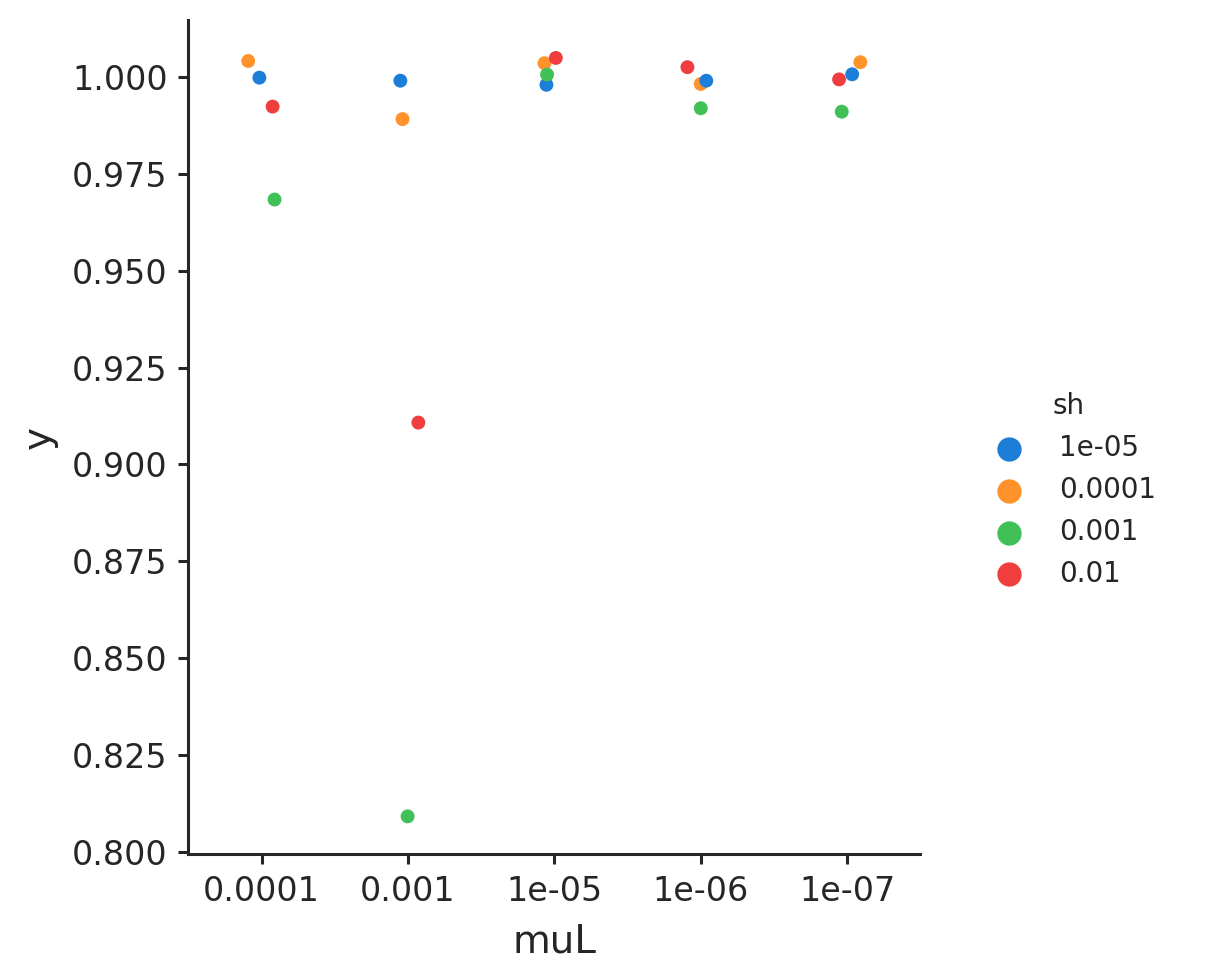

In [121]:
sns.catplot(x='muL', y='y', hue='sh', data=vd_means.loc[vd_means['L'] == 10_000])

## Recombination in the Segment

In [56]:
vd = load_validation('../data/slim_sims/validate_rbp/validate_rbp.npz')

In [59]:
vd['rbp'].unique()

array([1.e-09, 1.e-10, 1.e-07, 1.e-08])

<AxesSubplot:xlabel='sh', ylabel='y'>

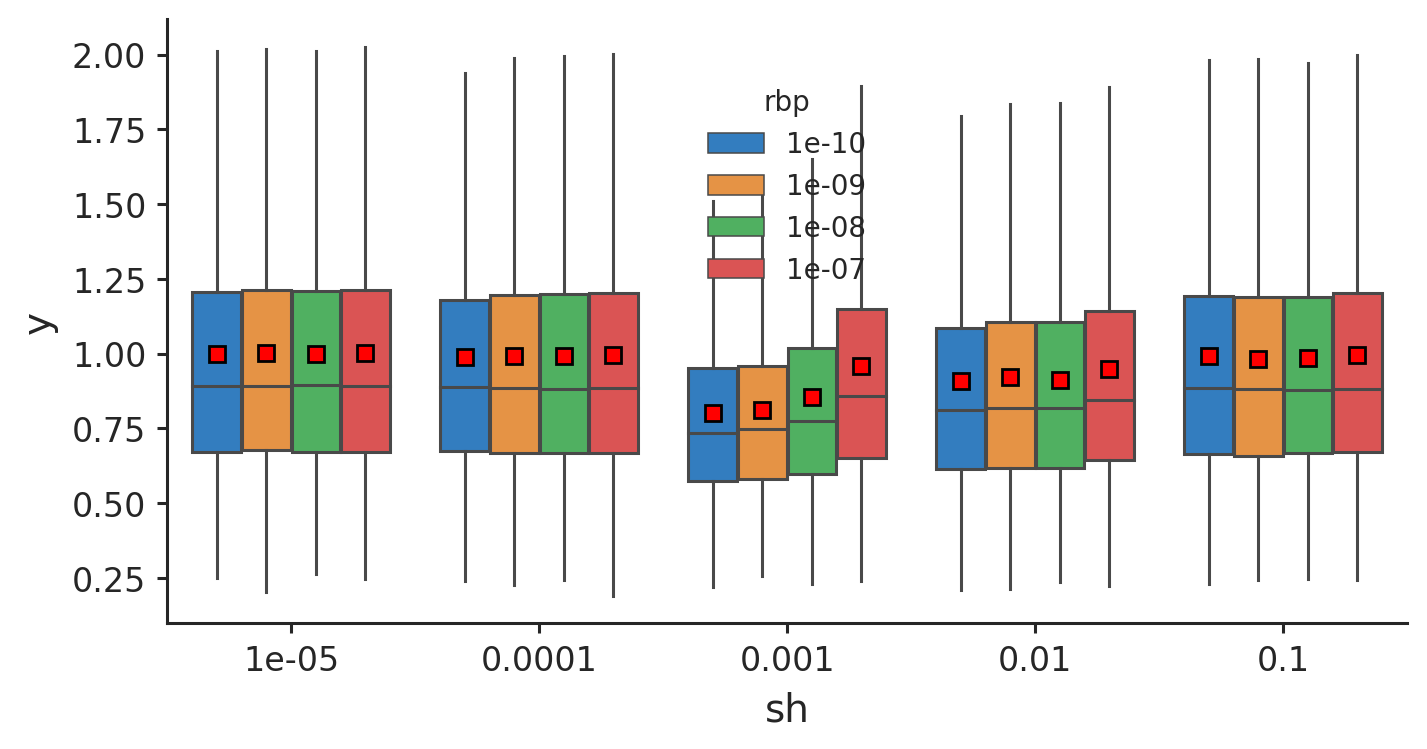

In [63]:
sns.boxplot(x='sh', y='y', hue='rbp', data=vd, showmeans=True)

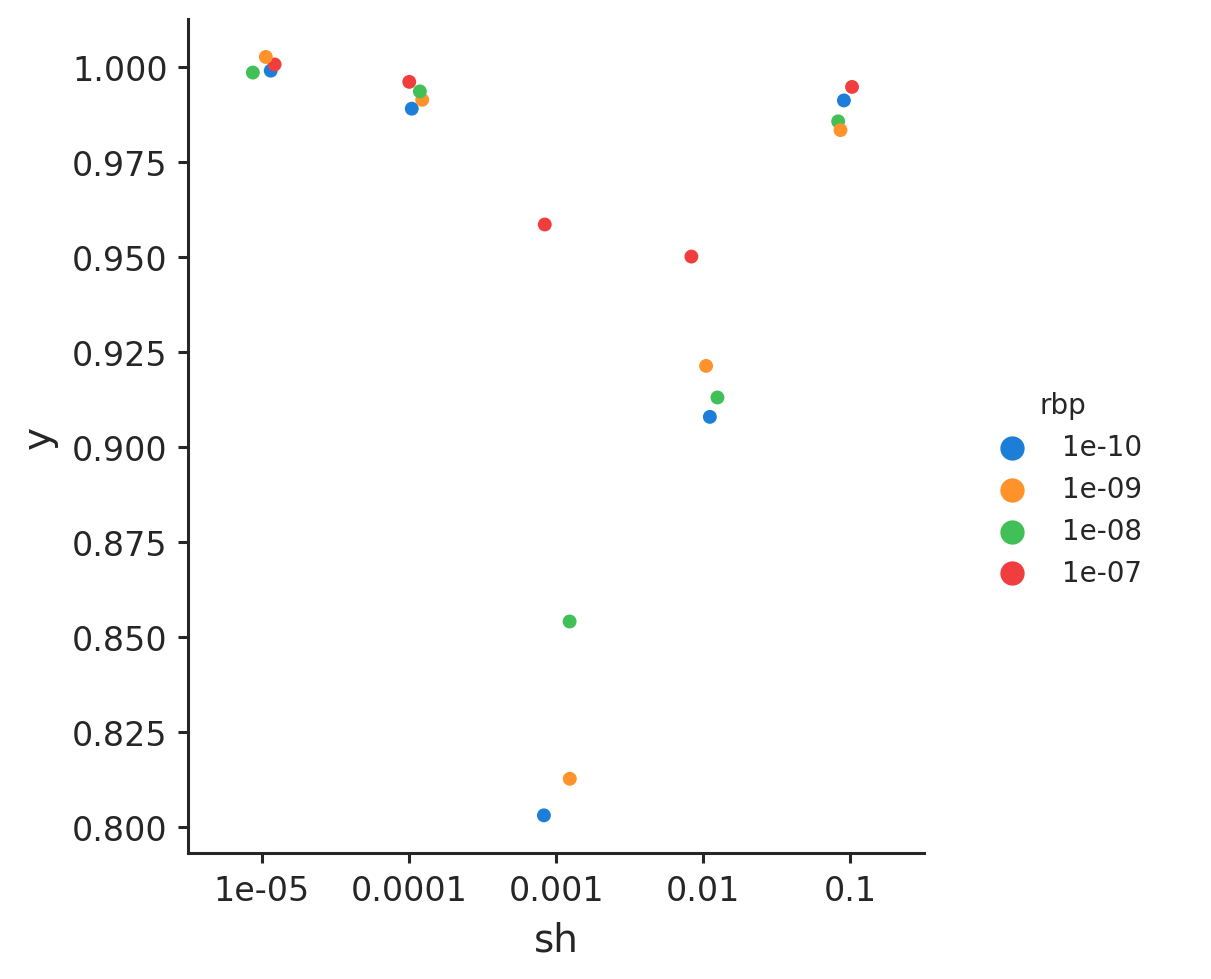

In [70]:
vd_means = group_means(vd)
vd_means['rbp'] = [signif(x, 2) for x in vd_means['rbp']]
sns.catplot(x='sh', y='y', hue='rbp', data=vd_means)